Author: Lijing Wang, lijing52@stanford.edu; David Yin, yinzhen@stanford.edu; Jef Caers, jcaers@stanford.edu (2020)

In [ ]:
## Clone data from our GitHub repository
! git clone https://github.com/lijingwang/GEOLSCI6_EARTHSYS100A.git
## load compositional data analysis package
! pip install scikit-bio

Cloning into 'GEOLSCI6_EARTHSYS100A'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 213 (delta 2), reused 9 (delta 2), pack-reused 203
Receiving objects: 100% (213/213), 22.70 MiB | 20.55 MiB/s, done.
Resolving deltas: 100% (88/88), done.
     |████████████████████████████████| 8.4MB 8.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for hdmedians: filename=hdmedians-0.14.2-cp37-cp37m-linux_x86_64.whl size=454521 sha256=bfe2b05a962c24c2ffeb94a09195ce04d15c71cb76e8d344b40c1a0da697264c
  Stored in directory: /root/.cache/pip/wheels/ed/ce/56/3127a24e951c79b03a71ae5d0ba0da4042252cd05c0665973f
Successfully built hdmedians
  Created wheel for scikit-bio: filename=scikit_bio-0.5.6-cp37-cp37m-linux_x86_64.whl size=1456748 sha256=2072482ebbc26f7e8912ca42

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from skbio.stats.composition import *
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load geochem dataset, groundwater chemistry in Central Valley
data = pd.read_csv('/content/GEOLSCI6_EARTHSYS100A/StatsGeochem/Datapoints-CentralValley-Groundwater-Jan2019.csv')
compositional_data = np.array(data.values[:,6:(6+22)],dtype = 'float64')
columns_name = data.columns[6:(6+22)]

# Principal component analysis (PCA)

The goal of PCA is to tranform high dimensional data to a linear combination of fewer and uncorrelated variables, with retaining most information. 

In geoscientific data analysis, PCA can be a robust statistical tool to reduce data dimensionality and extract main data features. The data features extracted by PCA are widely used to facilitate machine learning of geoscientific data. 

$$V = \begin{bmatrix}
    V_1\\
    V_2
  \end{bmatrix}  =   \begin{bmatrix}
    t_{11} & t_{12} \\
    t_{21} & t_{22}
  \end{bmatrix}\begin{bmatrix}
    X_1\\
    X_2
  \end{bmatrix} = TX $$ 

$$V_1 = t_{11}*X_1+t_{12}*X_2$$
$$V_2 = t_{21}*X_1+t_{22}*X_2$$

$V$: PC scores \\
$T$: PC loadings

$X$: Bivariate dataset after centering, removed the mean

## PCA on Cr and As contaminants - bivariate
To understand PCA, let's start with performing PCA on Cr and As elements:

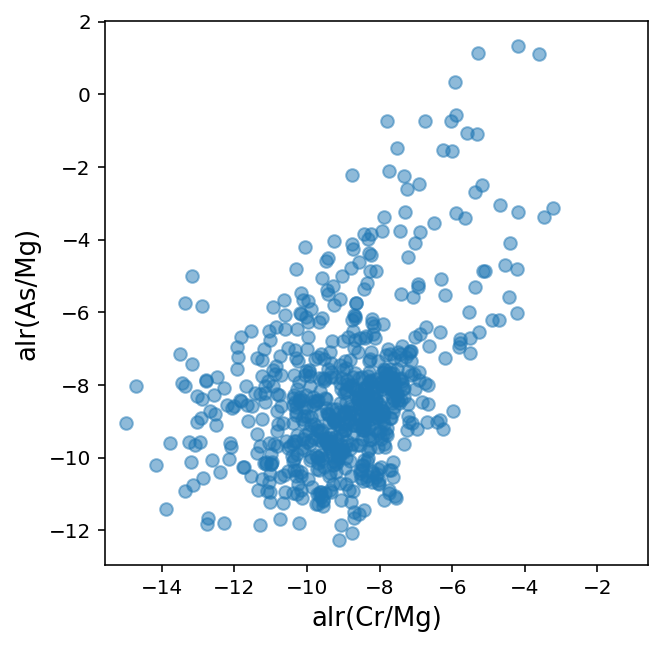

In [ ]:
plt.figure(figsize=(6,5))
X = np.c_[np.log(data['Cr (ppb)']/data['Mg (ppb)']), 
          np.log(data['As (ppb)']/data['Mg (ppb)'])]
plt.scatter(X[:,0], X[:,1], s=40, alpha=0.5)
plt.xlabel('alr(Cr/Mg)', fontsize = 13)
plt.ylabel('alr(As/Mg)', fontsize = 13)
plt.axis('square')
plt.show()

Before even thinking about PCA, let's simply transform the data as follows by taking the sum and the difference of the alr
* seting x-axis as $\frac{alr(Cr/Mg) + alr(As/Mg)}{2}$ 

* seting y-axis as $\frac{alr(Cr/Mg) - alr(As/Mg)}{2}$ 
 


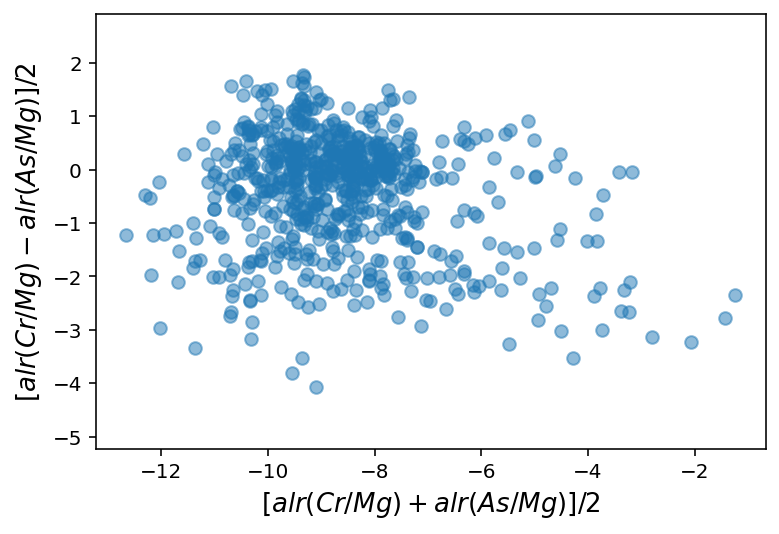

In [ ]:
plt.figure(figsize=(6,4))
X = np.c_[np.log(data['Cr (ppb)']/data['Mg (ppb)']), 
          np.log(data['As (ppb)']/data['Mg (ppb)'])]
plt.scatter((X[:,0]+X[:,1])/2, (X[:,0]-X[:,1])/2, s=40, alpha=0.5)
plt.xlabel('${[alr(Cr/Mg) + alr(As/Mg)]}/2$', fontsize = 13)
plt.ylabel('${[alr(Cr/Mg) - alr(As/Mg)]}/2$', fontsize = 13)
plt.axis('equal')
plt.show()

What do we notice? We notice two things: the sum has more variance than the difference, and the sum and the difference have almost no correlation. This is intriging because it suggest that the sum is more relevant in the data than the difference, and that these two can be used indepednetly. In PCA, this is exactly what we are looking for, except that it will be slightly more complicated than taking a sum or difference!

### 1st and 2nd principal components



Here we cimply extend from the biplot idea. 

The first principal component (PC1) has the shortest distances to all points. It lies in the direction where the data varies most. The second PC (PC2) is orthogonal to the first PC. 

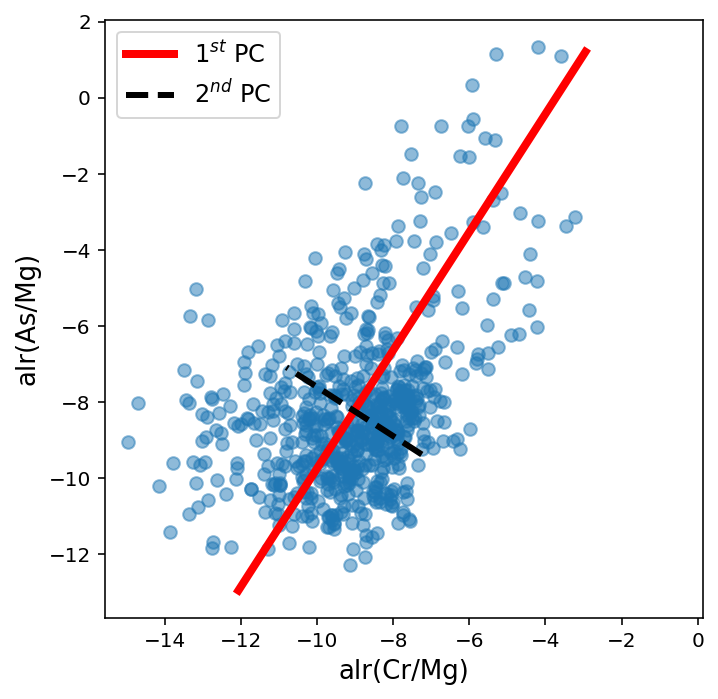

In [ ]:
pca = PCA(n_components=X.shape[1])
pca.fit(X)

plt.figure(figsize=(7,5.5))

## plot first component
plt.scatter(X[:,0], X[:,1], s=40, alpha=0.5)
comp = pca.components_[0] * pca.explained_variance_[0]  
plt.plot([-comp[0]+X[:,0].mean(), 2*comp[0]+X[:,0].mean()], 
         [-comp[1]+X[:,1].mean(), 2*comp[1]+X[:,1].mean()], label="1$^{st}$ PC", linewidth=4, color='r')
comp = pca.components_[1] * pca.explained_variance_[1]  
plt.plot([-comp[0]+X[:,0].mean(), comp[0]+X[:,0].mean()], 
         [-comp[1]+X[:,1].mean(), comp[1]+X[:,1].mean()], linewidth=3, color='k', label="2$^{nd}$ PC",linestyle='--')
plt.axis('square')
plt.xlabel('alr(Cr/Mg)', fontsize = 13)
plt.ylabel('alr(As/Mg)', fontsize = 13)
plt.legend(fontsize = 12)
plt.show()


### project data onto PCs

**1st principal component (PC1)**:

The data projection onto the first principal component has the highest variance. Let's test this statement.

Below we rotate x-, y-axises around the data center (mean) to the 1st and 2nd PCs. This gives us the tranformed co-oordinates as PCs. We then project data on to PC1. 

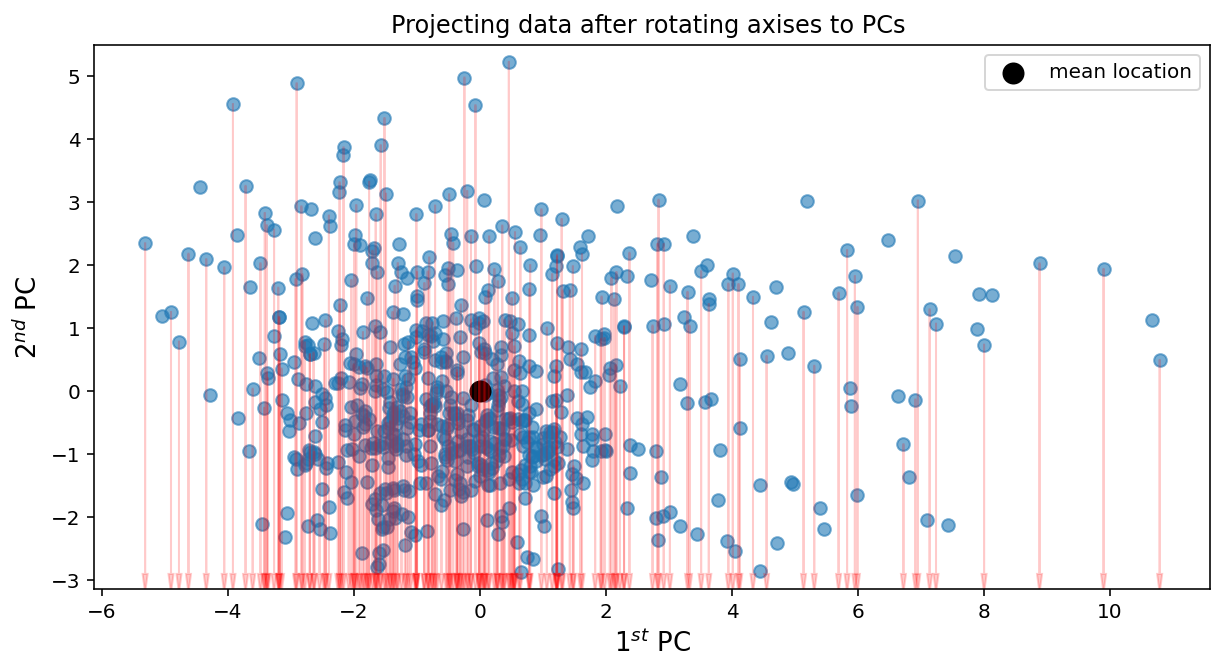

In [ ]:
# rotate the data based on PCs
plt.figure(figsize=(10,5))

X_pc = pca.transform(X)

for i in range(200):
  plt.arrow(X_pc[i,0], X_pc[i,1], 0, -X_pc[i,1]-2.9, color='r', alpha=0.2,head_width=0.08, head_length=0.3)
plt.scatter(X_pc[:,0], X_pc[:,1], s=40, alpha=0.6)
plt.scatter(0,0, s=100, c='k',label='mean location')
plt.title('Projecting data after rotating axises to PCs ')
plt.legend()
plt.xlabel('1$^{st}$ PC', fontsize = 13)
plt.ylabel('2$^{nd}$ PC', fontsize = 13)
plt.axis('equal')
plt.show()

We then plot the variances of projecting data onto PC1 versus projecting onto directions off PC1

<img src='https://drive.google.com/uc?export=view&id=1xIEgj09k-gjQdfCd59RZr9A4uViHAW7r' width=40% />


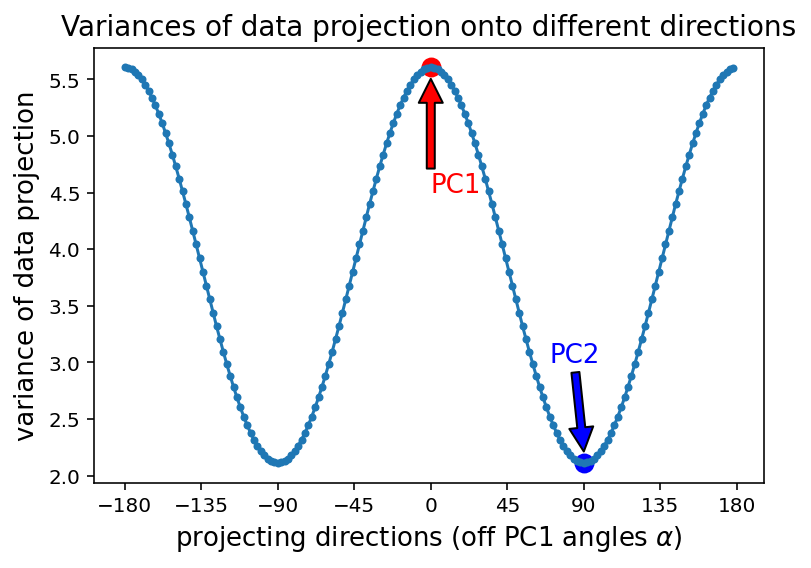

In [ ]:
import math
vars = []
for angle in range(-180,180, 2):
  x, y = math.cos(angle * math.pi/180), math.sin(angle * math.pi/180)
  vec = np.array([x, y]).reshape(2, 1)
  vars.append(np.var(X_pc.dot(vec)))
plt.plot(np.arange(-180, 180, 2), vars, '.-')
plt.scatter(0, max(vars), c='r', s=80)
plt.scatter(90, min(vars), c='b', s=80)
plt.annotate('PC1', xy=(0, max(vars)-0.1), xytext=(0, 4.5),
            arrowprops=dict(facecolor='red', width=4), fontsize=13, color='r')
plt.annotate('PC2', xy=(90, min(vars)+0.1), xytext=(70, 3),
            arrowprops=dict(facecolor='b', width=4), fontsize=13, color='b')
plt.ylabel('variance of data projection', fontsize=13)
plt.xlabel('projecting directions (off PC1 angles $α$)', fontsize=13)
plt.title('Variances of data projection onto different directions', fontsize=14)
plt.xticks([-180, -135, -90, -45, 0, 45, 90, 135, 180])
# plt.plot(scatter, '.')
plt.show()

The figure above shows that projecting data onto PC1 has the maximum variance.



**2nd principal component (PC2)**:

Projecting data to PC2 will have the remaining data variance. Here we visualize this statement. 

In figure below, we remove the data variance in PC1. We can see that all the data collapsed in PC1 direction. It is obvious that PC2 retain all the remaining variance. 

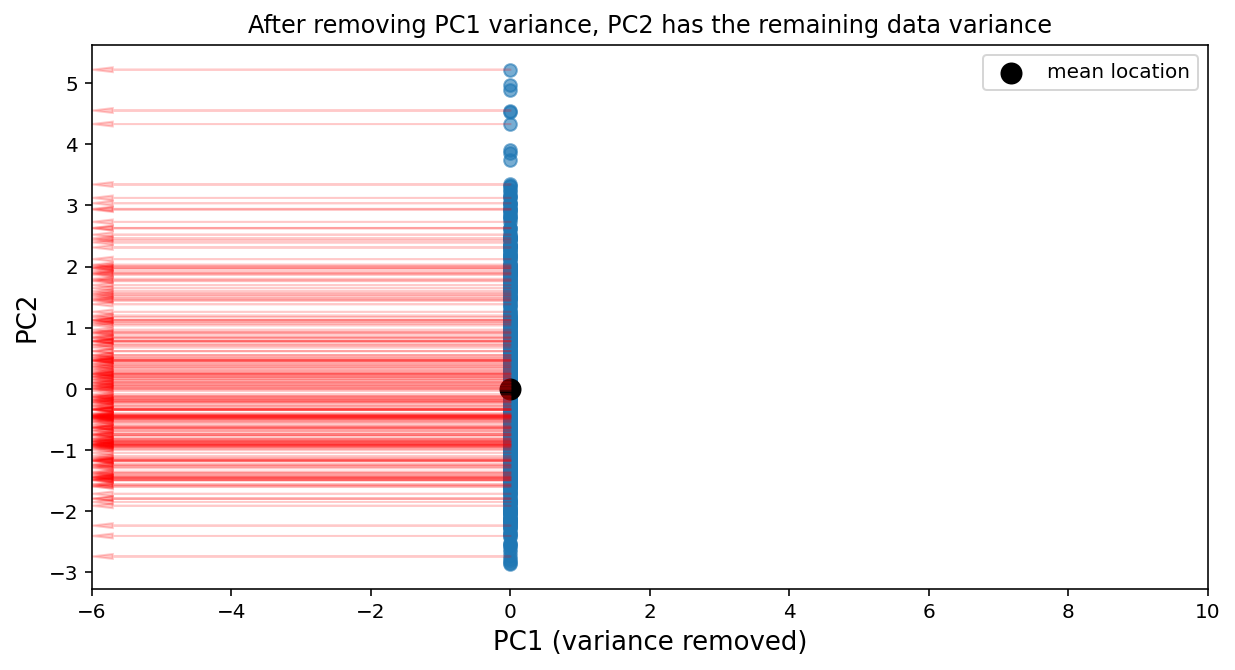

In [ ]:
# rotate the data based on PCs
plt.figure(figsize=(10,5))

X_pc = pca.transform(X)

for i in range(1,650,3):
  plt.arrow(0, X_pc[i,1], -5.7, 0, color='r', alpha=0.2,head_width=0.08, head_length=0.3)
plt.scatter(X_pc[:,0]*0, X_pc[:,1], s=40, alpha=0.6)
plt.scatter(0,0, s=100, c='k',label='mean location')
plt.title('After removing PC1 variance, PC2 has the remaining data variance')
plt.legend()
plt.xlabel('PC1 (variance removed)', fontsize = 13)
plt.ylabel('PC2', fontsize = 13)
plt.xlim(-6, 10)
plt.show()

### PC loadings

We turn PC1 and PC2 into unit vectors. Then loadings are elements in each PC (unit norm) scaled by their corresponding variance. 

* The loadings indicate how much each variable contributes to a particular principal component. Large loadings (positive or negative) indicate that a particular variable has a strong relationship to a particular principal component. 
* The +/- sign of a loading means whether a variable and a principal component are +/- correlated.

Here we plot the loadings for alr(Cr/Mg) and alr(As/Mg). 

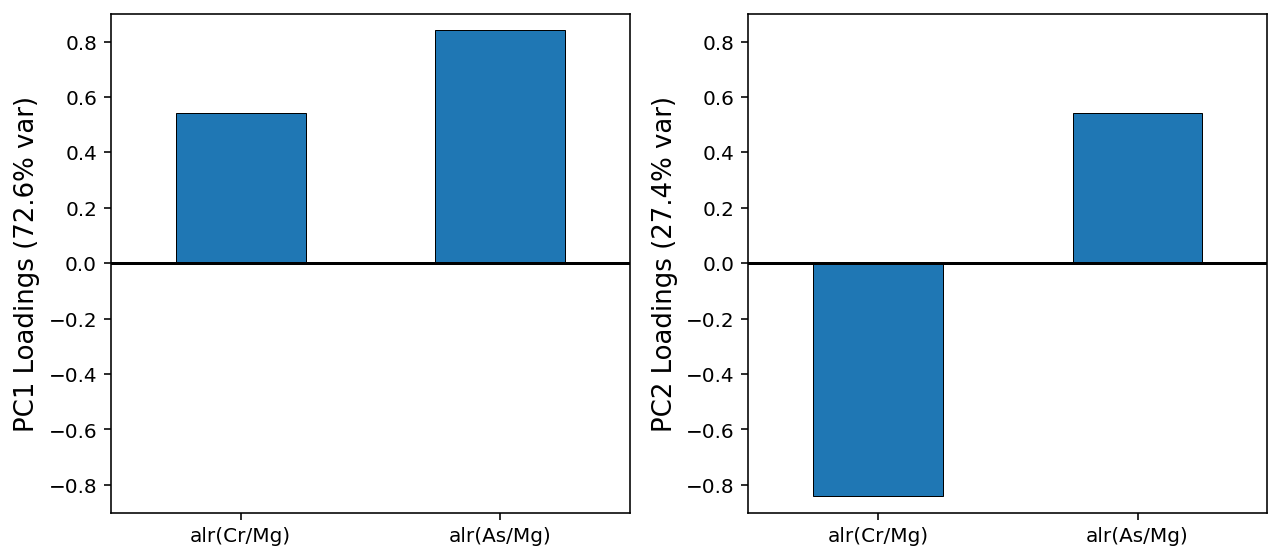

In [ ]:
plt.figure(figsize=(9,4))
for i in range(2):
  plt.subplot(1, 2, i+1)
  plt.bar(['alr(Cr/Mg)', 'alr(As/Mg)'], pca.components_[i], edgecolor='k', linewidth=0.5, width=0.5)
  plt.hlines(y=0, xmin=-1, xmax=2 )
  plt.xlim(-0.5, 1.5)
  plt.ylim(-0.9, 0.9)
  plt.ylabel('PC'+str(i+1)+' Loadings ({:.1f}% var)'.format(100*pca.explained_variance_ratio_[i]), fontsize=13)
plt.tight_layout()


We can observe both alr(Cr/Mg) and alr(As/Mg) are positively correlated to PC1 (retaining 72.6% variance). alr(As/Mg) is more contributing than alr(As/Mg) to PC1. 

At PC2 retaining 27.4% variance, alr(Cr/Mg) is dominating and negatively correlated to PC2. 

### PC scores

By projecting data on to the PC transformed co-ordinates, we obtain the "**PC scores**". 

* The scores are representations of data in principal component space. 

* At each PC, number of scores is corresponding to number of data observations. In this bivariate Cr, As log ratio example, there are totally 683 observations, so we have 683 scores at each PC. 

* For each geochemical data observation $X_i$:

   $X_i = PC1(loadings)*PC1(score)_i +PC2(loadings)*PC2(score)_i$

Below, we plot the scores in PC1 and PC2. 

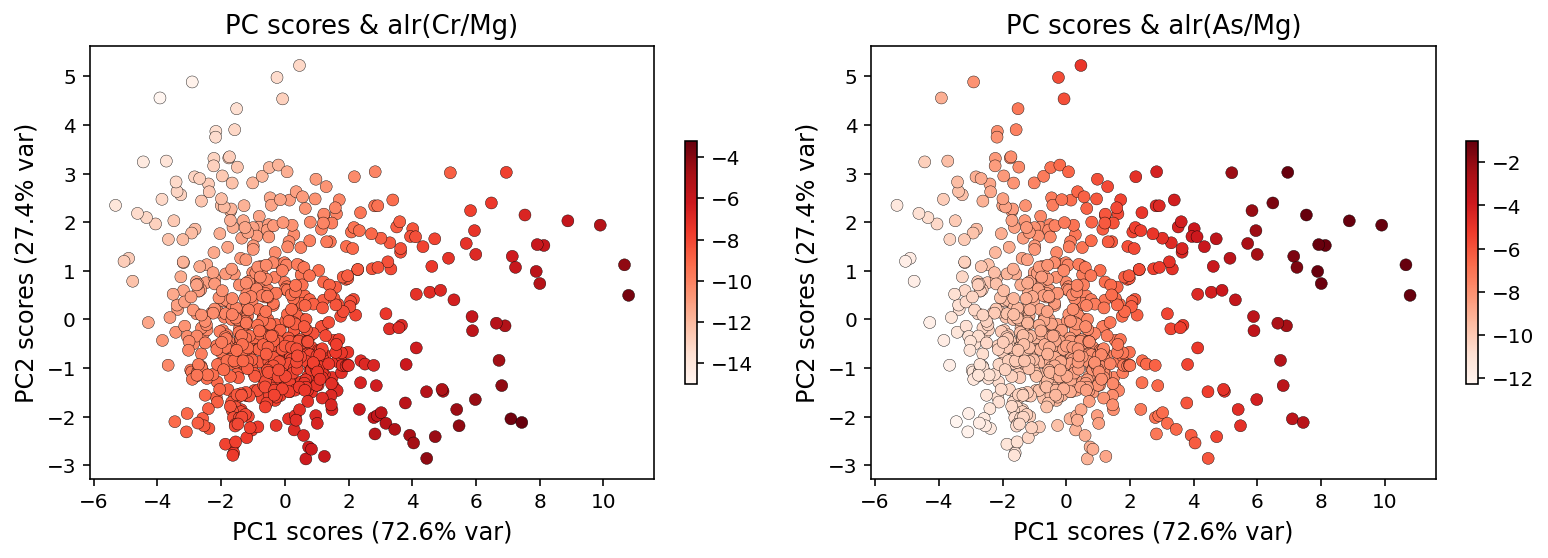

In [ ]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.scatter(X_pc[:,0], X_pc[:,1],  c=np.log(data['Cr (ppb)']/data['Mg (ppb)']), 
            cmap = 'Reds', edgecolor='k', linewidth=0.2)
plt.colorbar(fraction=0.02)
plt.xlabel('PC1 scores ({:.1f}% var)'.format(100*pca.explained_variance_ratio_[0]), fontsize=12)
plt.ylabel('PC2 scores ({:.1f}% var)'.format(100*pca.explained_variance_ratio_[1]), fontsize=12)
plt.title('PC scores & alr(Cr/Mg)', fontsize=13)

plt.subplot(122)

plt.scatter(X_pc[:,0], X_pc[:,1],  c=np.log(data['As (ppb)']/data['Mg (ppb)']), 
            cmap = 'Reds', edgecolor='k', linewidth=0.2, vmax=-1)
plt.colorbar(fraction=0.02)
plt.xlabel('PC1 scores ({:.1f}% var)'.format(100*pca.explained_variance_ratio_[0]), fontsize=12)
plt.ylabel('PC2 scores ({:.1f}% var)'.format(100*pca.explained_variance_ratio_[1]), fontsize=12)
plt.title('PC scores & alr(As/Mg)', fontsize=13)
plt.tight_layout()

From the loadings, we have konwn PC1 is dominated by As log ratio. Therefore, we observe from the left plot that PC1 scores increase with the increase of As log ratio. While at PC2, the scores are nagatively correlated to Cr log ratio. 

We can also project the scores to central valley map. 

Try to explain what do you observe, and what are your interpretations?

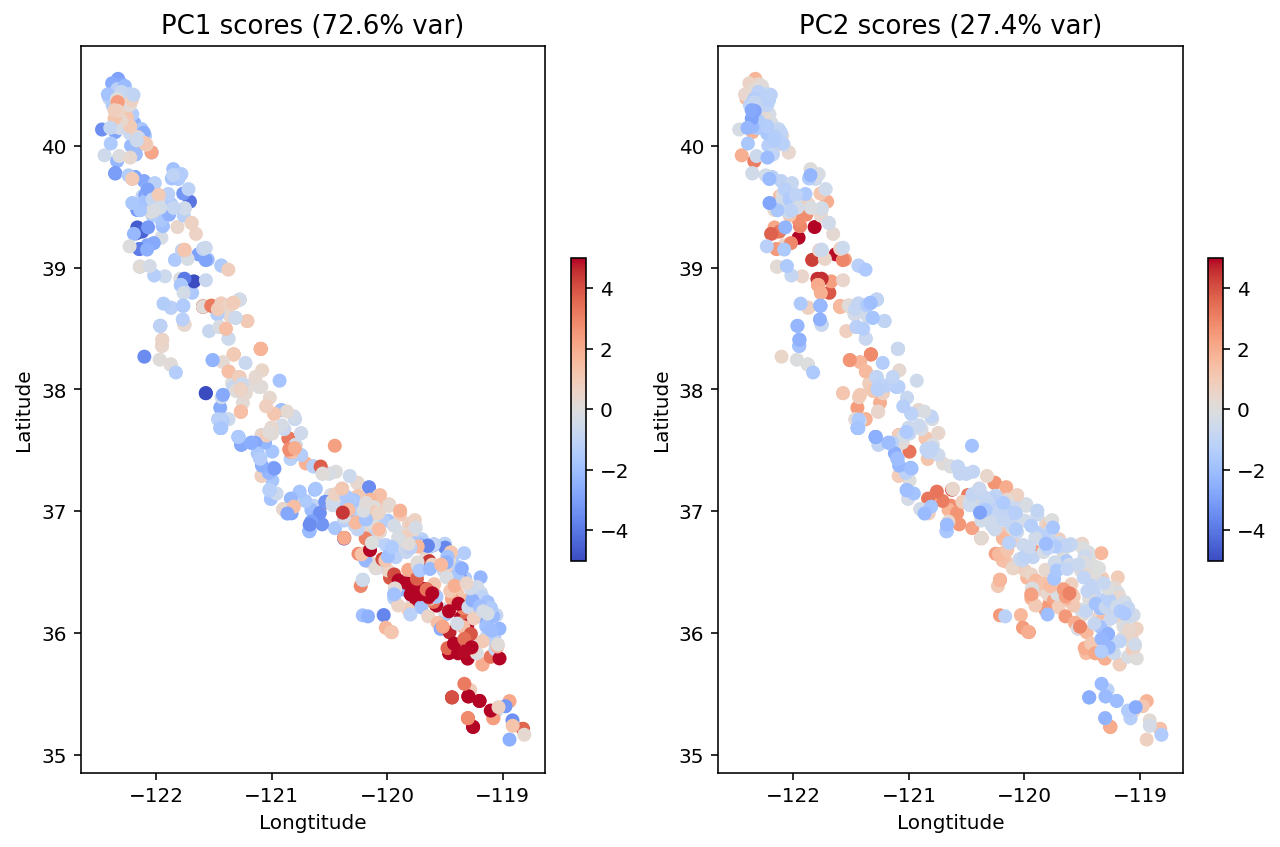

In [ ]:
plt.figure(figsize=(9,6))
plt.subplot(121)
plt.scatter(data['Longitude'],data['Latitude'],
            c = X_pc[:,0], cmap = 'coolwarm',vmin=-5, vmax = 5)
plt.colorbar(fraction=0.03)
plt.title('PC1 scores ({:.1f}% var)'.format(100*pca.explained_variance_ratio_[0]), fontsize=13)
plt.xlabel('Longtitude')
plt.ylabel('Latitude')

plt.subplot(122)
plt.scatter(data['Longitude'],data['Latitude'],
            c = X_pc[:,1],cmap = 'coolwarm',vmin=-5, vmax = 5)
plt.colorbar(fraction=0.03)
plt.title('PC2 scores ({:.1f}% var)'.format(100*pca.explained_variance_ratio_[1]), fontsize=13)
plt.xlabel('Longtitude')
plt.ylabel('Latitude')
plt.tight_layout()

## How to perform PCA (use Cr, As dataset example)

1. Center the Cr, As dataset by subtracting the mean of Cr and As respectively, obtaining centered data $X$. 

In [ ]:
X = X-X.mean(axis=0)


2. Compute covariance matrix of $X$. 
$$X^{T}X$$


In [ ]:
cov_mat = X.T.dot(X)

3. Perform eigendecompositon on the covariance matrix.
$$X^{T}X = T\Lambda T^T$$
* $T=(t_1, t_2)$. $t_1, t_2$ are the eigenvectors/transformation (PCs) and $t_1 \perp t_2$.   $TT^T=I$ ($I$: identity matrix). 
* $\Lambda = diag(\lambda_1, \lambda_2)$. $\lambda_1, \lambda_2$ are eigenvalues which are the variance of data projections on each PC. 


In [ ]:
lamda, T = np.linalg.eig(cov_mat)

4. Project centered Cr, As dataset $X$  onto the choosen principal components.


In [ ]:
PC_score = X.dot(T)

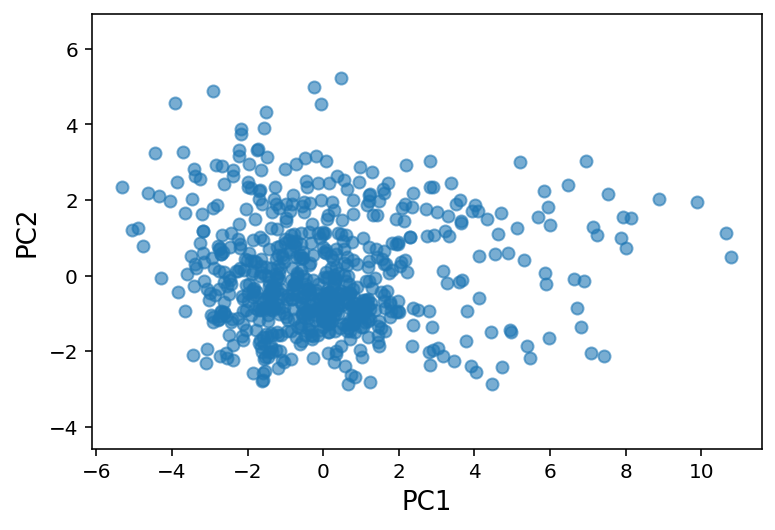

In [ ]:
plt.scatter(-PC_score[:,1], PC_score[:,0], alpha=0.6)
plt.xlabel('PC1', fontsize = 13)
plt.ylabel('PC2', fontsize = 13)
plt.axis('equal')
plt.show()

## Cr, As, Mn, NO$_3$ - multivariate PCA


For high-dimensional multivariate data, PCA is a powerful tool to 
* 1. reduce dimensionality of multivariate data
* 2. extract main data features. 

Now, let perform PCA on a larger multivariate dataset, by including log ratios of Cr, As, Mn and NO3 with Mg as basis. 

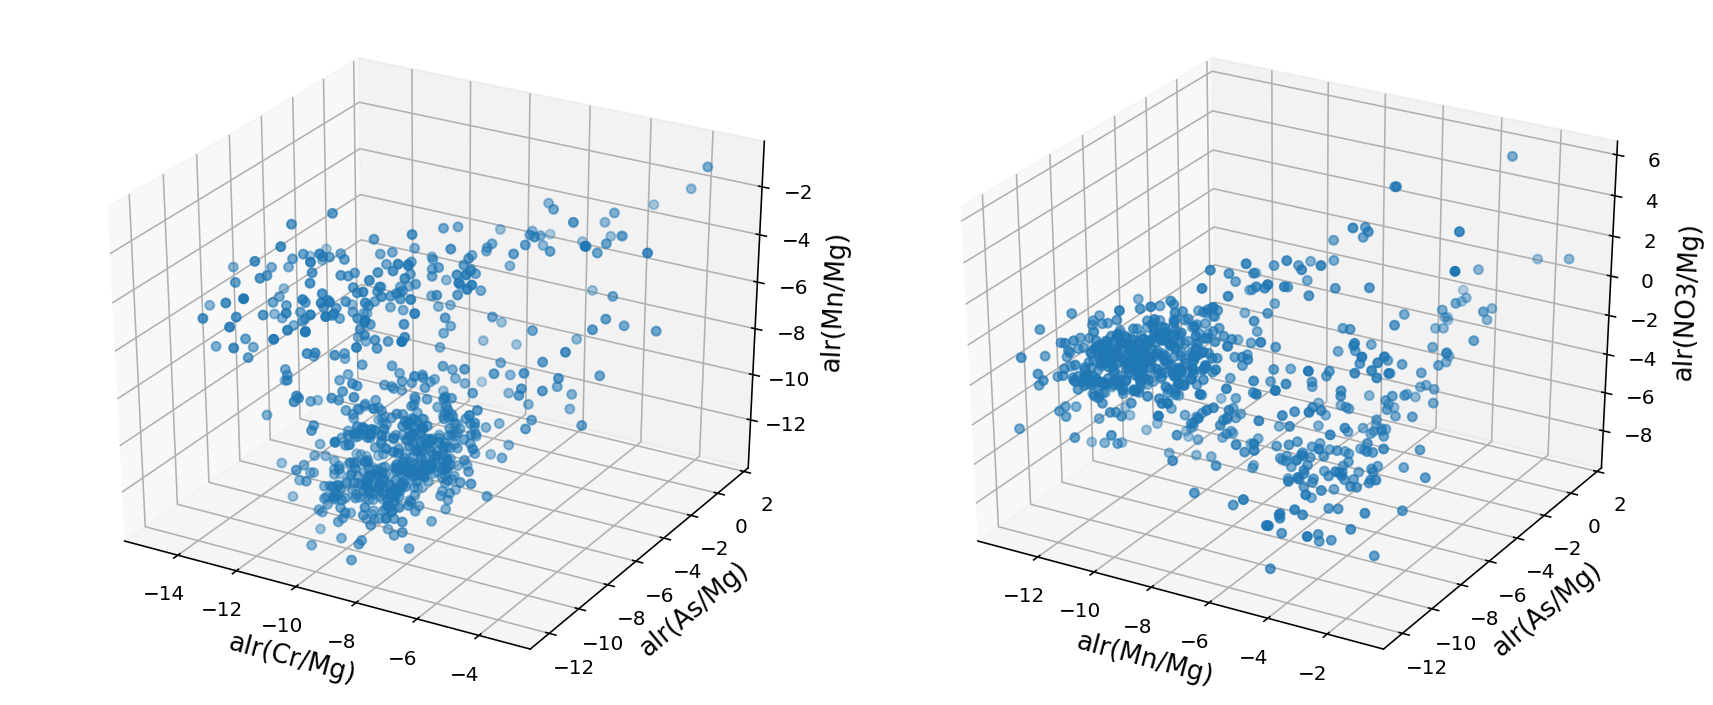

In [ ]:
X = np.c_[np.log(data['Cr (ppb)']/data['Mg (ppb)']), 
          np.log(data['As (ppb)']/data['Mg (ppb)']), 
          np.log(data['Mn (ppb)']/data['Mg (ppb)']),
          np.log(data['NO3 (ppb)']/data['Mg (ppb)'])]
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[:,0],X[:,1], X[:,2])
ax.set_xlabel('alr(Cr/Mg)', fontsize = 13)
ax.set_ylabel('alr(As/Mg)', fontsize = 13)
ax.set_zlabel('alr(Mn/Mg)', fontsize = 13)

ax = fig.add_subplot(122, projection='3d')
ax.scatter(X[:,2],X[:,1], X[:,3])
ax.set_xlabel('alr(Mn/Mg)', fontsize = 13)
ax.set_ylabel('alr(As/Mg)', fontsize = 13)
ax.set_zlabel('alr(NO3/Mg)', fontsize = 13)

plt.tight_layout()

**Perform PCA**

In multivariate data, the maximum number of PCs is determined by the rank of data matrix $X$ , termed as $rank(X)$. 

If $X$ is a $n × p$ matrix. $rank(X)<=min(n, p)$

In our geochemistry example, $X$ is a (683,4) matrix, with $rank(X)=4$. We therefore can decompose the data to 4 principal components

In [ ]:
## determine PC numbers by rank of data matrix. 
n_pcs = np.linalg.matrix_rank(X)

In [ ]:
## Run PCA
pca = PCA(n_components=n_pcs)
pca.fit(X)
X_pc = pca.transform(X)

In multivariate PCA, PC1 still explains the maximum variance of data. 

The $i^{th}$ PC retains the maximum of the remaining variances after removing previous ($i-1$) PCs. 

In the plot below (named "Scree Plot"), we show how much varaince each PC retains in this geochemistry example.  


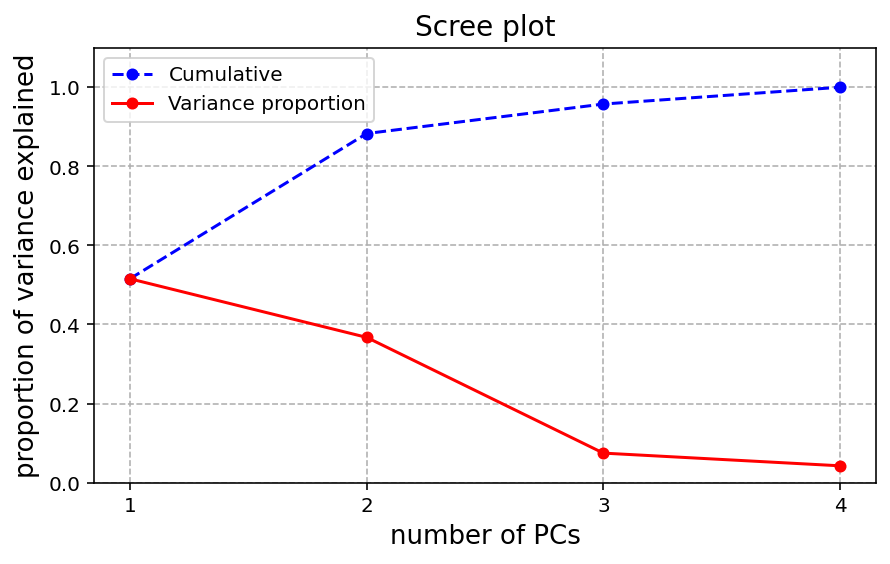

In [ ]:
plt.figure(figsize=(7, 4))
plt.plot(np.arange(1,X.shape[1]+1), pca.explained_variance_ratio_.cumsum(), \
          marker='o', markersize=5, linestyle = 'dashed', color='blue', label='Cumulative')
plt.plot(np.arange(1,X.shape[1]+1), pca.explained_variance_ratio_, \
          marker='o', markersize=5, color='red', label='Variance proportion')
plt.xlabel('number of PCs', fontsize = 13)
plt.ylabel('proportion of variance explained', fontsize = 13)
plt.xticks(np.arange(1,X.shape[1]+1,1))
plt.ylim(0,1.1)
plt.legend()
plt.title('Scree plot', fontsize = 14)
plt.grid(linestyle='dashed')

We observe from the plot that $i^{th}$ PC explains the maximum of the remaining variability . 

Here, PC1 and PC2 explain nearly 90% of the total data variability, with the last two PCs (PC3, PC4) only  retaining remaining 10%. This suggests that the 4-dimensional geochemical data can be represented with two dimensions (PC1 and PC2). 

Similarly to the bivariate example, we can also plot PC loadings

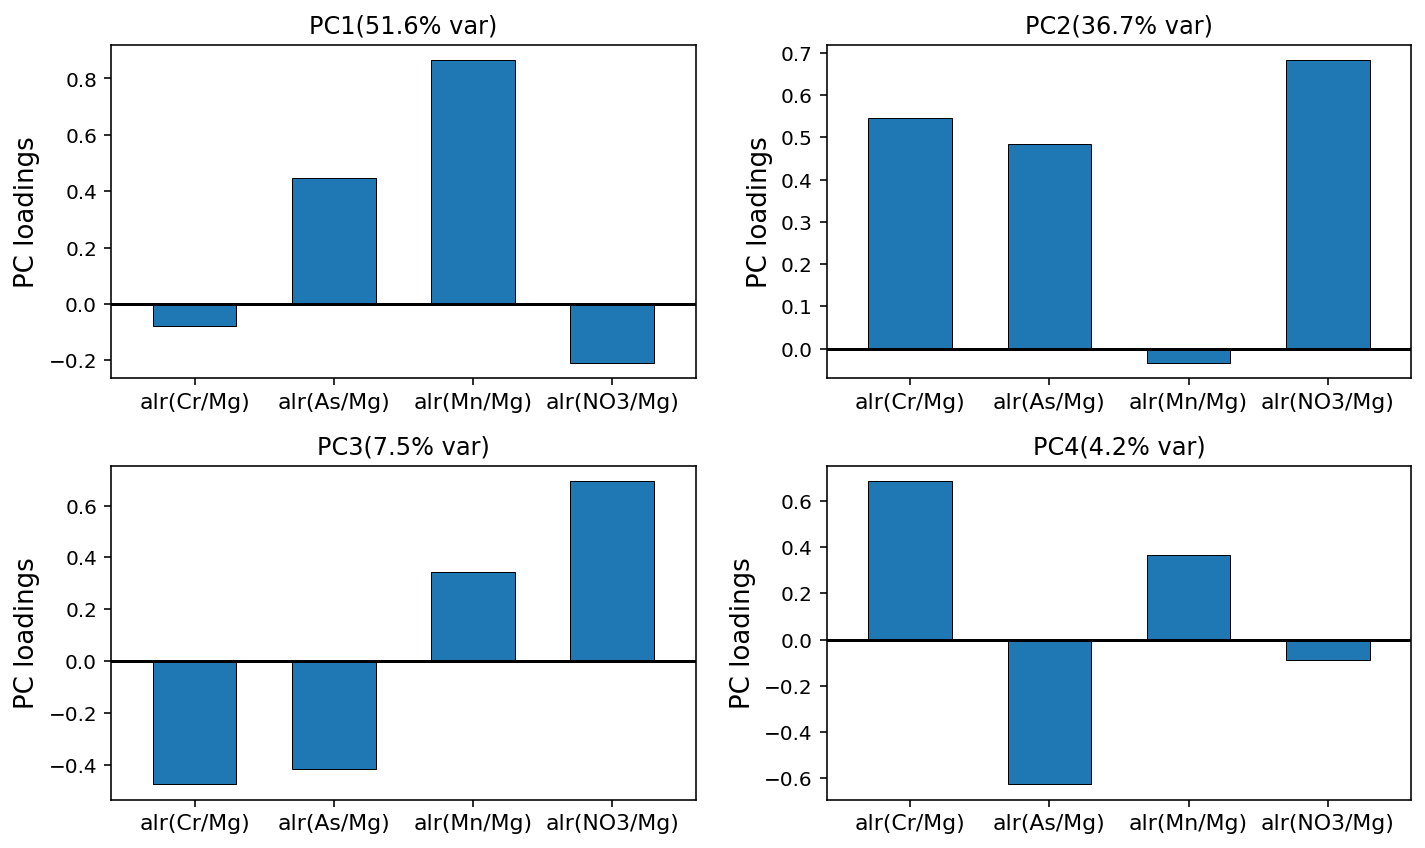

In [ ]:
plt.figure(figsize=(10,6))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.bar(['alr(Cr/Mg)', 'alr(As/Mg)', 'alr(Mn/Mg)',  'alr(NO3/Mg)'], 
          pca.components_[i], edgecolor='k', linewidth=0.5, width=0.6)
  plt.hlines(y=0, xmin=-1, xmax=3.6 )
  plt.ylabel('PC loadings', fontsize=13)
  plt.xticks(fontsize=11)
  plt.title('PC'+str(i+1)+'({:.1f}% var)'.format(100*pca.explained_variance_ratio_[i]))
  plt.xlim(-0.6,3.6)
plt.tight_layout()


From the loadings, we find that PC2 are contributed mostly by contaminats Cr, As with NO3. 

You can then make a scatter plot of the PC1 and PC2 scores. On the plot, we show the distribution of Cr, As and NO3 values.

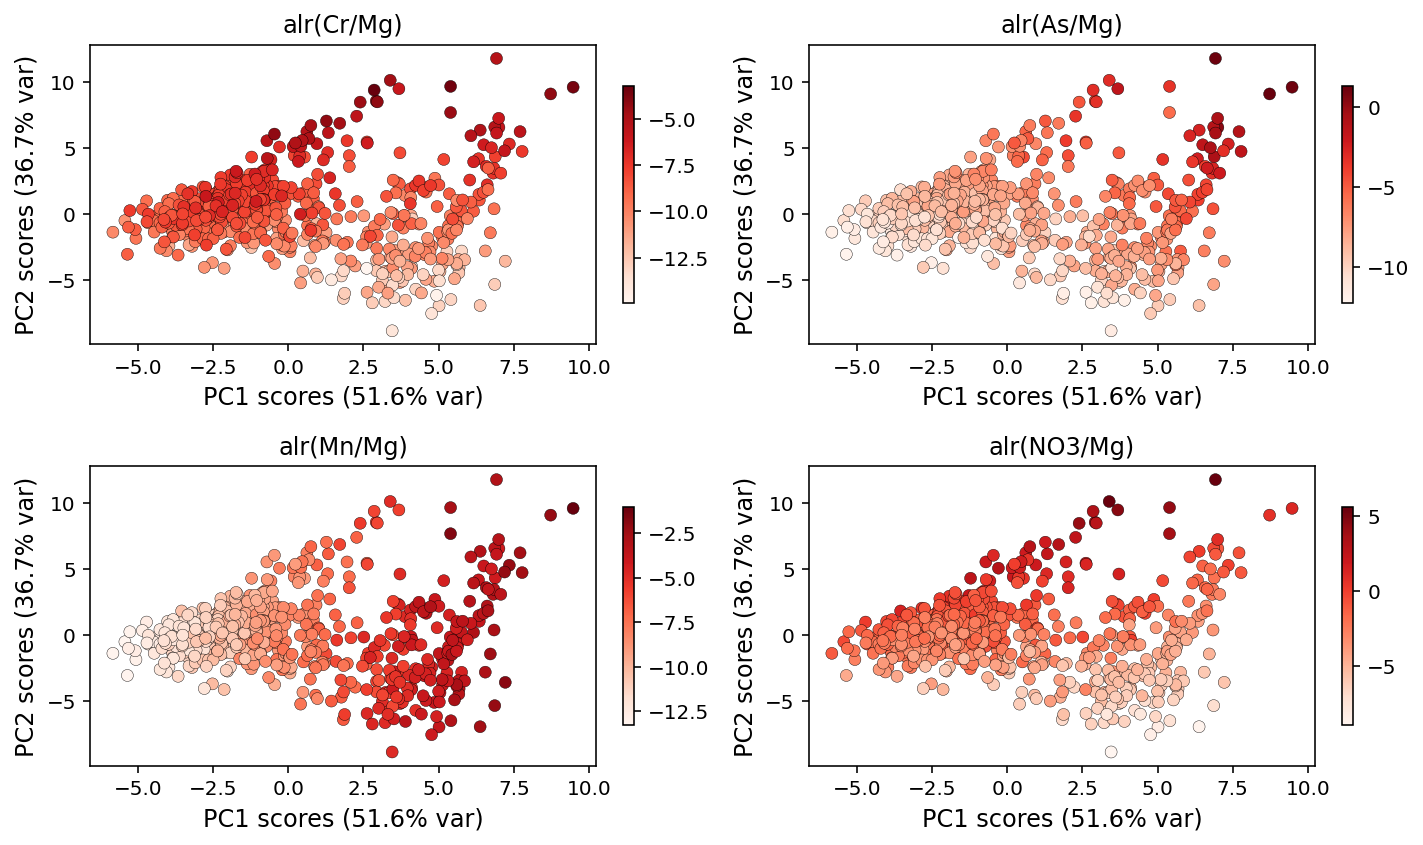

In [ ]:
geochem = ['Cr (ppb)', 'As (ppb)', 'Mn (ppb)', 'NO3 (ppb)' ]
alr_name= ['alr(Cr/Mg)', 'alr(As/Mg)', 'alr(Mn/Mg)', 'alr(NO3/Mg)']

plt.figure(figsize=(10,6))
for i in range(len(geochem)):
  plt.subplot(2, 2, i+1)
  plt.scatter(X_pc[:,0], X_pc[:,1],  c=np.log(data[geochem[i]]/data['Mg (ppb)']), 
              cmap = 'Reds', edgecolor='k', linewidth=0.2)
  # plt.scatter(X_pc[:,1],  np.log(data[geochem[i]]/data['Mg (ppb)']), 
  #             edgecolor='k', linewidth=0.2)
  plt.colorbar(fraction=0.02)
  plt.ylabel('PC2 scores ({:.1f}% var)'.format(100*pca.explained_variance_ratio_[1]), fontsize=12)
  plt.xlabel('PC1 scores ({:.1f}% var)'.format(100*pca.explained_variance_ratio_[0]), fontsize=12)

  plt.title(alr_name[i], fontsize=12)
plt.tight_layout()

To confirm the correlations between PC2 and and Cr, As, NO3 log ratios, we make the regression plot between PC2 scores and each geochemical element.   

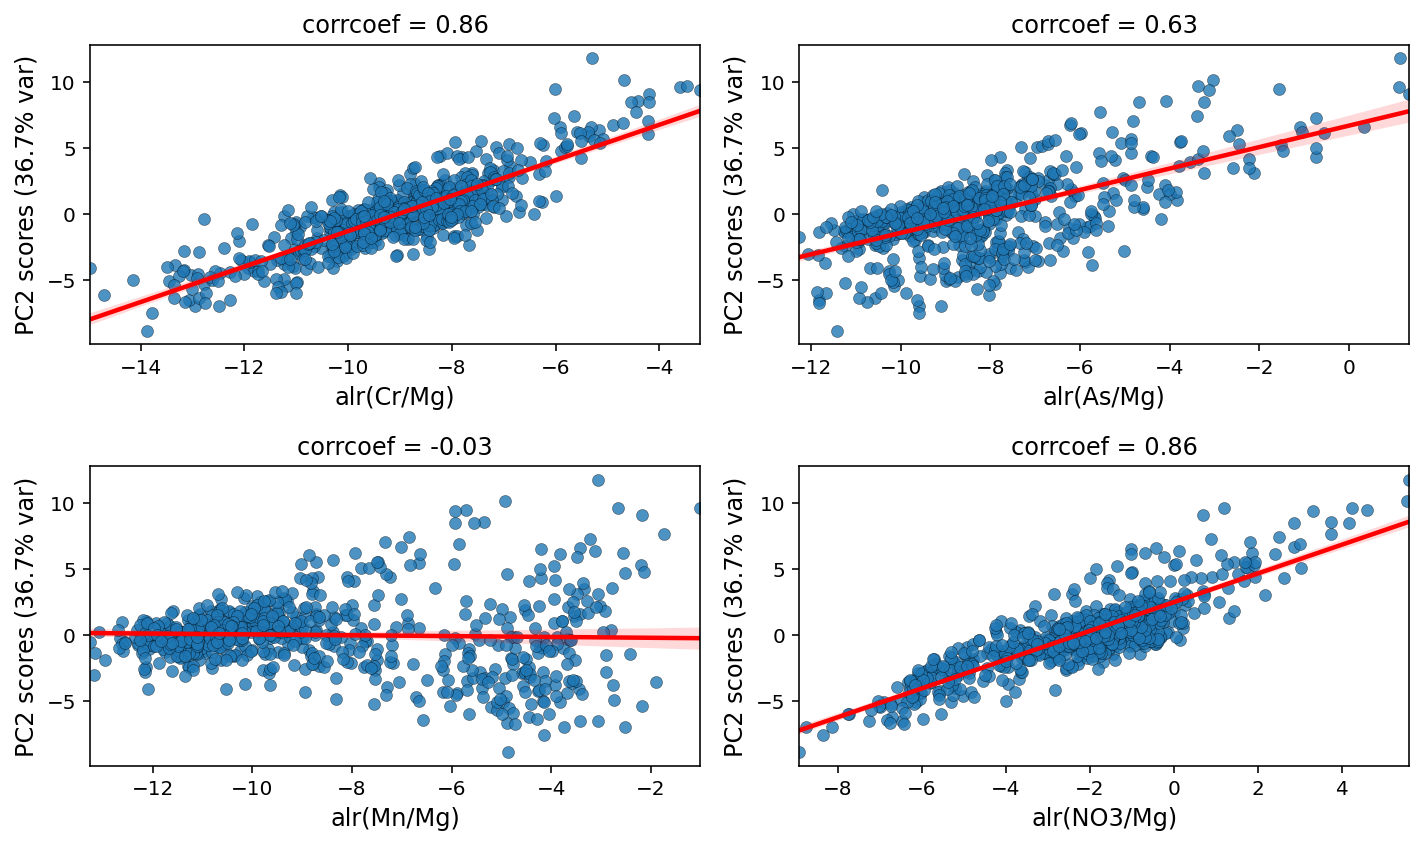

In [ ]:
plt.figure(figsize=(10,6))
for i in range(len(geochem)):
  plt.subplot(2, 2, i+1)
  sns.regplot(np.log(data[geochem[i]]/data['Mg (ppb)']), X_pc[:,1], 
              scatter_kws={"alpha": 0.8, 'edgecolor':'k', 'linewidth':0.2}, 
              line_kws={"color": "red"})
  coeff = np.corrcoef(np.log(data[geochem[i]]/data['Mg (ppb)']), X_pc[:,1])[0,1]
  plt.title('corrcoef = {:.2f}'.format(coeff))
  plt.ylabel('PC2 scores ({:.1f}% var)'.format(100*pca.explained_variance_ratio_[1]), fontsize=12)
  plt.xlabel(alr_name[i], fontsize=12)
plt.tight_layout()

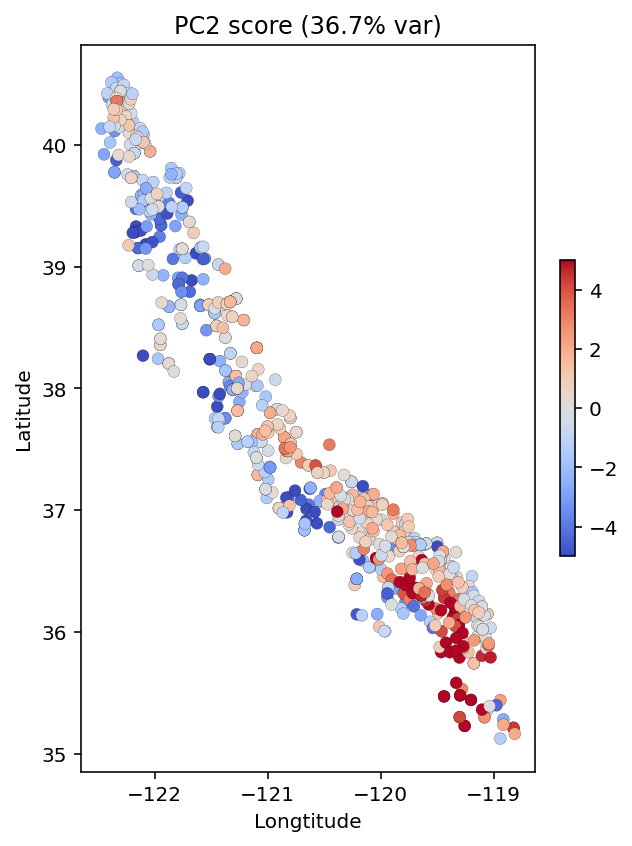

In [ ]:
plt.figure(figsize=(4.5,6))
plt.scatter(data['Longitude'],data['Latitude'],
            c = X_pc[:,1], cmap = 'coolwarm', vmax=5, vmin=-5, edgecolor='k', linewidth=0.1)
plt.colorbar(fraction=0.03)
plt.title('PC2 score ({:.1f}% var)'.format(100*pca.explained_variance_ratio_[1]))

plt.xlabel('Longtitude')
plt.ylabel('Latitude')
plt.tight_layout()

## Reconstruction - inverse PCA 

One important advantage of PCA is that it can be bijectively revsersed back to the orignial variables. 


Reconstruction $X = T^T V = T^{-1}V$: 


$$X_1' = t_{11}*V_1+t_{21}*V_2$$
$$X_2' = t_{12}*V_1+t_{22}*V_2$$
$$X_3' = t_{13}*V_1+t_{23}*V_2$$
$$X_4' = t_{14}*V_1+t_{24}*V_2$$

$$ X' =T^T V$$

where $X'$ is the reconstructed $X$ using PCs. 

For large dimensional data, a few number of PCs with large explained variances can reconstruct a good approximation to the original data. 

In the multivariate geochemical example, we only use PC1 and PC2 to reconstruct the orignial chemical data. 

In [ ]:
X_rec =  X_pc[:,:2].dot(pca.components_[:2]) + X.mean(axis=0)

Plot reconstructed results

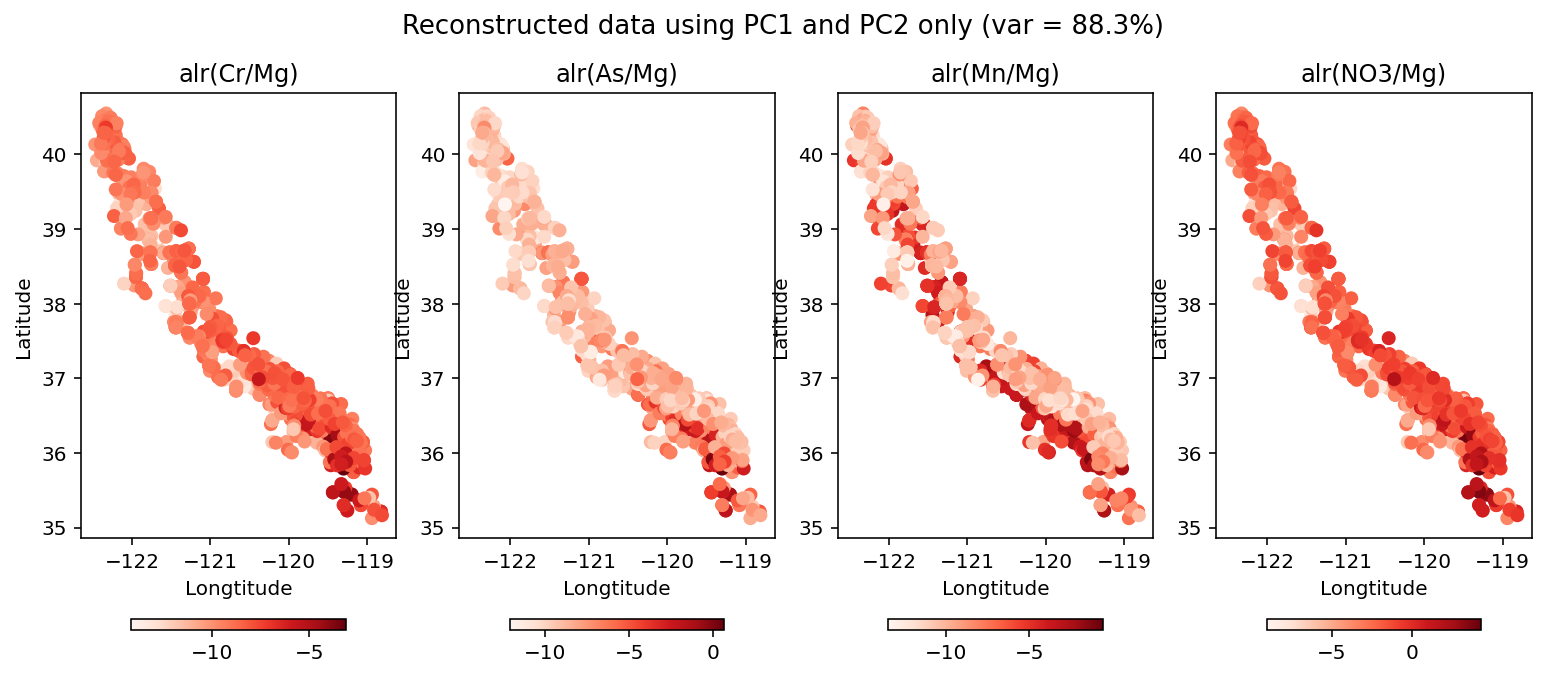

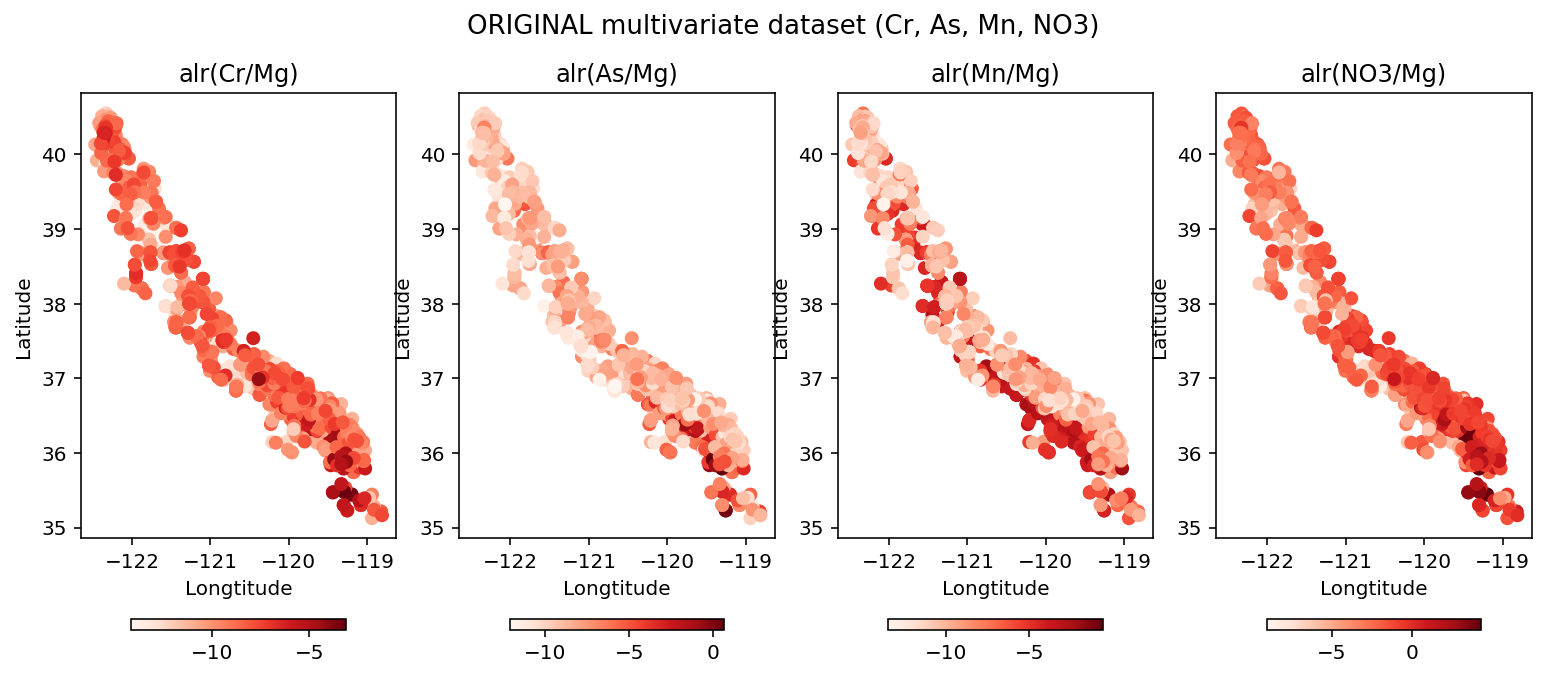

In [ ]:
plt.figure(figsize=(13,5))
for i in range(4):
  plt.subplot(1,4,i+1)
  plt.scatter(data['Longitude'],data['Latitude'],
              c = X_rec[:,i],cmap = 'Reds', vmin = X_rec[:,i].min(), vmax = X_rec[:,i].max())
  plt.colorbar(fraction=0.02, orientation='horizontal')
  plt.title(alr_name[i])
  plt.xlabel('Longtitude')
  plt.ylabel('Latitude')
plt.subplots_adjust(top=0.87)
plt.suptitle('Reconstructed data using PC1 and PC2 only (var = 88.3%)', fontsize=13)
plt.show()
plt.figure(figsize=(13,5))
for i in range(4):
  plt.subplot(1,4,i+1)
  plt.scatter(data['Longitude'],data['Latitude'],
              c = X[:,i],cmap = 'Reds',vmin = X_rec[:,i].min(), vmax = X_rec[:,i].max())
  plt.colorbar(fraction=0.02, orientation='horizontal')
  plt.xlabel('Longtitude')
  plt.ylabel('Latitude')
  plt.title(alr_name[i])
plt.subplots_adjust(top=0.87)
plt.suptitle('ORIGINAL multivariate dataset (Cr, As, Mn, NO3)', fontsize=13)
plt.show()

We can observe a very good match between the reconstructed and original data. 

This suggests PCA is a powerful tool to compress data by reducing data dimensions. 

We can also quantify the reconstruction errors between X' and X as:
$$ Error = \sum_{i = 1}(X_i-X_i')^2 $$

In [ ]:
error = np.sum(np.linalg.norm(X_rec-X, axis=1)**2)

If we devide the error by $ \sum_{i = 1}X_i^2 $:
$$ Error/\sum_{i = 1}X_i^2$$

In [ ]:
error.sum()/np.sum(X**2, axis=1).sum()

0.009930660562428684

You can find that there are about 10% of reconstruction error. This is about the amount of variances in remaining PCs.  

# Principal component analysis, bivariate, one principal component

Maximize the **explained variance** of the first component 


$$V = \begin{bmatrix}
    V_1\\
    V_2
  \end{bmatrix}  =   \begin{bmatrix}
    t_{11} & t_{12} \\
    t_{21} & t_{22}
  \end{bmatrix}\begin{bmatrix}
    X_1\\
    X_2
  \end{bmatrix} = TX $$ 

$$V_1 = t_{11}*X_1+t_{12}*X_2$$
$$V_2 = t_{21}*X_1+t_{22}*X_2$$

$V$: PC scores \\
$T$: PC loadings, $T = \begin{bmatrix}
    t_{11} & t_{12} \\
    t_{21} & t_{22}
  \end{bmatrix} = \begin{bmatrix}
    0.542 & 0.841\\
    -0.841 & 0.542\\
  \end{bmatrix} $ \\
$X$: Bivariate dataset after centering, removed the mean



Reconstruction $X = T^T V = T^{-1}V$: 

$$X_1 = t_{11}*V_1+t_{21}*V_2$$
$$X_2 = t_{12}*V_1+t_{22}*V_2$$

Suppose we only have $P_1$ as the independent/explanatory/predictor variable: 


$$X_1 = t_{11}*V_1+e_1$$
$$X_2 = t_{12}*V_1+e_2$$





In [ ]:
X = np.c_[np.log(data['Cr (ppb)']/data['Mg (ppb)']), 
          np.log(data['As (ppb)']/data['Mg (ppb)'])]

In [ ]:
pca = PCA(n_components=X.shape[1])
pca.fit(X)
X_pc = pca.transform(X)

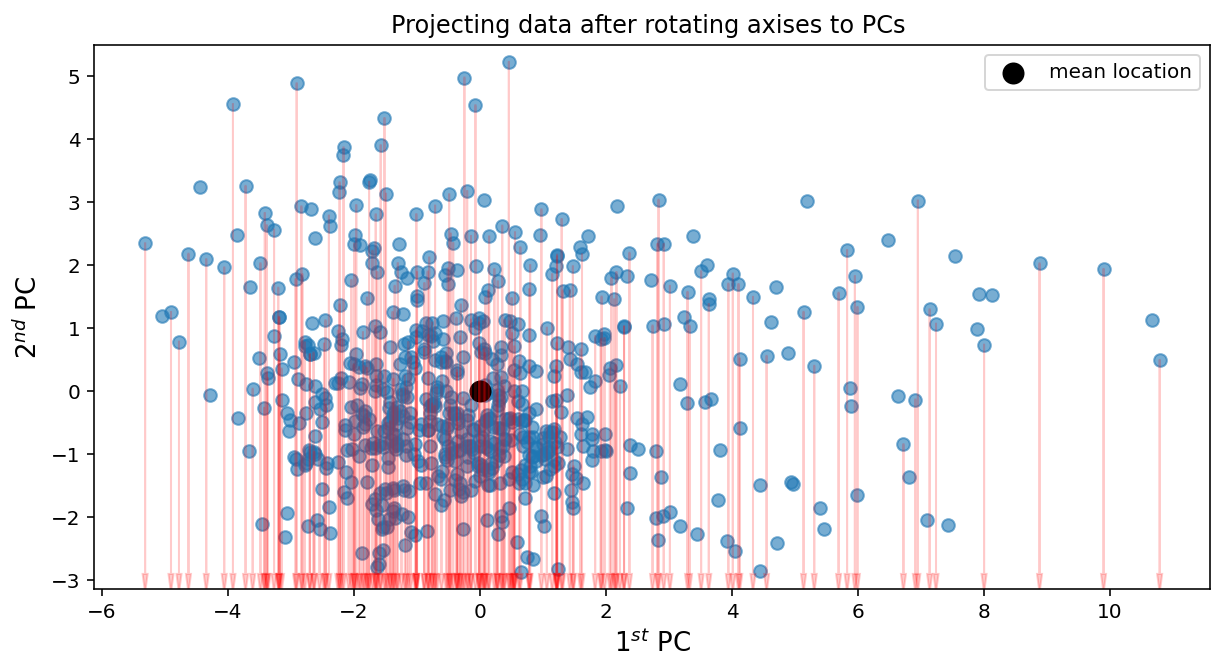

In [ ]:
# rotate the data based on PCs
plt.figure(figsize=(10,5))

X_pc = pca.transform(X)

for i in range(200):
  plt.arrow(X_pc[i,0], X_pc[i,1], 0, -X_pc[i,1]-2.9, color='r', alpha=0.2,head_width=0.08, head_length=0.3)
plt.scatter(X_pc[:,0], X_pc[:,1], s=40, alpha=0.6)
plt.scatter(0,0, s=100, c='k',label='mean location')
plt.title('Projecting data after rotating axises to PCs ')
plt.legend()
plt.xlabel('1$^{st}$ PC', fontsize = 13)
plt.ylabel('2$^{nd}$ PC', fontsize = 13)
plt.axis('equal')
plt.show()

Text(0, 0.5, 'Projection: t11*P1')

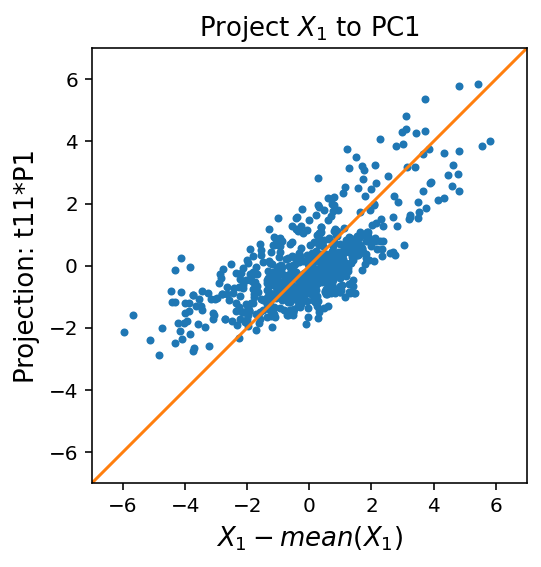

In [ ]:
plt.plot(X[:,0]-np.mean(X[:,0]),pca.components_[0,0]*X_pc[:,0],'.')
plt.gca().set(aspect='equal')
plt.plot([-7, 7], [-7, 7])
plt.xlim(-7,7)
plt.ylim(-7,7)
plt.title('Project $X_1$ to PC1', fontsize = 13)
plt.xlabel('$X_1-mean(X_1)$', fontsize = 13)
plt.ylabel('Projection: t11*P1', fontsize = 13)

Text(0, 0.5, 'Projection: t12*P1')

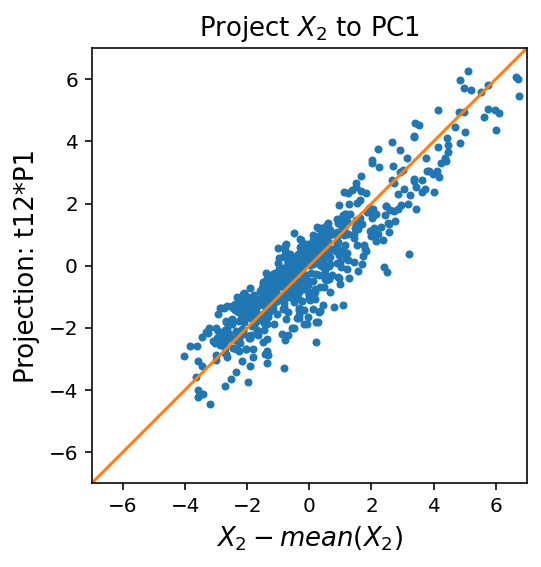

In [ ]:
plt.plot(X[:,1]-np.mean(X[:,1]),pca.components_[0,1]*X_pc[:,0],'.')
plt.gca().set(aspect='equal')
plt.plot([-7, 7], [-7, 7])
plt.xlim(-7,7)
plt.ylim(-7,7)
plt.title('Project $X_2$ to PC1', fontsize = 13)
plt.xlabel('$X_2-mean(X_2)$', fontsize = 13)
plt.ylabel('Projection: t12*P1', fontsize = 13)

Text(0, 0.5, 'e2 = t22*P2')

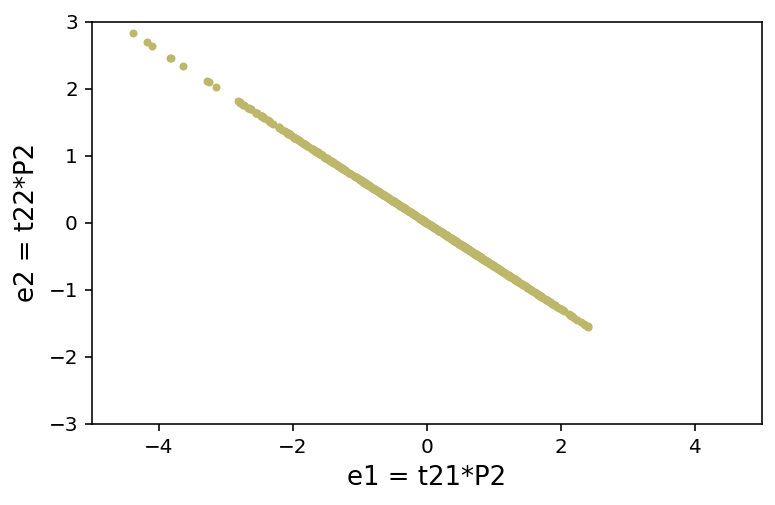

In [ ]:
plt.plot(X[:,0]-np.mean(X[:,0])-pca.components_[0,0]*X_pc[:,0],X[:,1]-np.mean(X[:,1])-pca.components_[0,1]*X_pc[:,0],'.',color = 'darkkhaki')
plt.gca().set(aspect='equal')
plt.xlim(-5,5)
plt.ylim(-3,3)
plt.xlabel('e1 = t21*P2', fontsize = 13)
plt.ylabel('e2 = t22*P2', fontsize = 13)

# Factor analysis, bivariate, one factor

The purpose of factor analysis: 

To describe variability among observed, correlated variables in terms of a potentially **lower number** of unobserved variables called **factors**. 

$F$ is the latent variable/unobserved variable/latent common factor.

Suppose we have one latent variable $F_1$:

$$X_1 =  l_{11}*F_1+\varepsilon_1$$
$$X_2 = l_{21}*F_1+\varepsilon_2$$



Note here all we can observe are $X_1$ and $X_2$, the left side of the equation. The common factor $F_1$, the unique part/error term $\varepsilon_1$ and $\varepsilon_2$, the weight/loading $l_{11}$ and $l_{21}$ are all unknown. 

So even though the above equations look like a multivariate linear regression, the underlying assumption is totally different. 


Let's again use the bivariate alr as an example:

In [ ]:
#@title
! pip install factor_analyzer

In [ ]:
X = np.c_[np.log(data['Cr (ppb)']/data['Mg (ppb)']), 
          np.log(data['As (ppb)']/data['Mg (ppb)'])]

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)

In [ ]:
from factor_analyzer import FactorAnalyzer
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors = 1, rotation = 'varimax',method='minres')
fa.fit(X)
X_fa =fa.transform(X)
X_fa_scaler = scaler.fit_transform(X_fa)

fa.loadings_ = fa.loadings_*(-1)
X_fa_scaler = X_fa_scaler*(-1)

Compare the vector direction with PCA: 

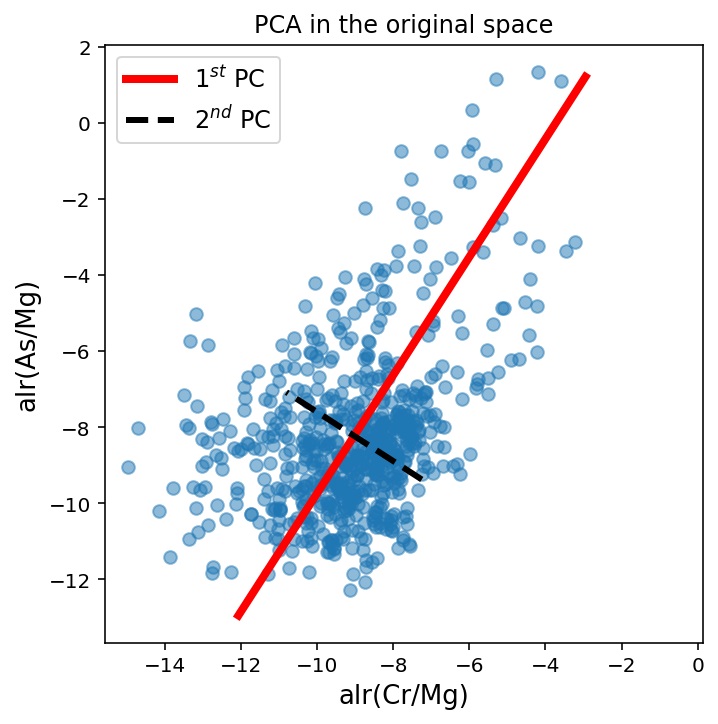

In [ ]:
pca = PCA(n_components=X.shape[1])
pca.fit(X)

plt.figure(figsize=(7,5.5))

## plot first component
plt.scatter(X[:,0], X[:,1], s=40, alpha=0.5)
comp = pca.components_[0] * pca.explained_variance_[0]  
plt.plot([-comp[0]+X[:,0].mean(), 2*comp[0]+X[:,0].mean()], 
         [-comp[1]+X[:,1].mean(), 2*comp[1]+X[:,1].mean()], label="1$^{st}$ PC", linewidth=4, color='r')
comp = pca.components_[1] * pca.explained_variance_[1]  
plt.plot([-comp[0]+X[:,0].mean(), comp[0]+X[:,0].mean()], 
         [-comp[1]+X[:,1].mean(), comp[1]+X[:,1].mean()], linewidth=3, color='k', label="2$^{nd}$ PC",linestyle='--')
plt.axis('square')
plt.xlabel('alr(Cr/Mg)', fontsize = 13)
plt.ylabel('alr(As/Mg)', fontsize = 13)
plt.legend(fontsize = 12)
plt.title('PCA in the original space')
plt.show()


In [ ]:
## transform PC components into a standardized space
pca = PCA(n_components=X.shape[1])
pca.fit(X)

scaler = StandardScaler(with_mean = False)
X_scaler = scaler.fit_transform(X)

pca.components_ = scaler.transform(pca.components_)

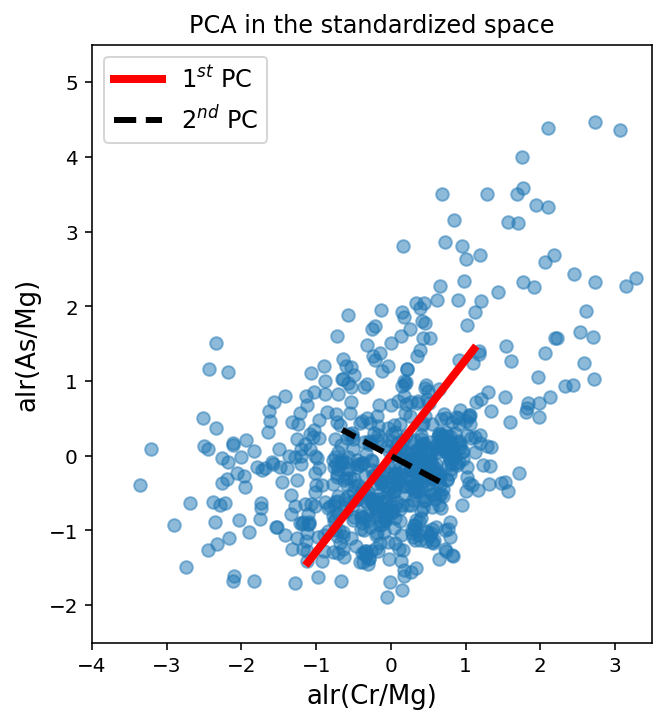

In [ ]:
plt.figure(figsize=(7,5.5))

scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)

## plot first component
plt.scatter(X_scaler[:,0], X_scaler[:,1], s=40, alpha=0.5)
comp = pca.components_[0] * pca.explained_variance_ratio_[0] 
vis_scale = 5 
plt.plot([-comp[0]*vis_scale, comp[0]*vis_scale], 
         [-comp[1]*vis_scale, comp[1]*vis_scale], label="1$^{st}$ PC", linewidth=4, color='r')
comp = pca.components_[1] * pca.explained_variance_ratio_[1]  
plt.plot([-comp[0]*vis_scale, comp[0]*vis_scale], 
         [-comp[1]*vis_scale, comp[1]*vis_scale], linewidth=3, color='k', label="2$^{nd}$ PC",linestyle='--')
plt.axis('square')
plt.xlabel('alr(Cr/Mg)', fontsize = 13)
plt.ylabel('alr(As/Mg)', fontsize = 13)
plt.title('PCA in the standardized space')
plt.legend(fontsize = 12)
plt.ylim(-2.5,5.5)
plt.xlim(-4,3.5)
plt.show()


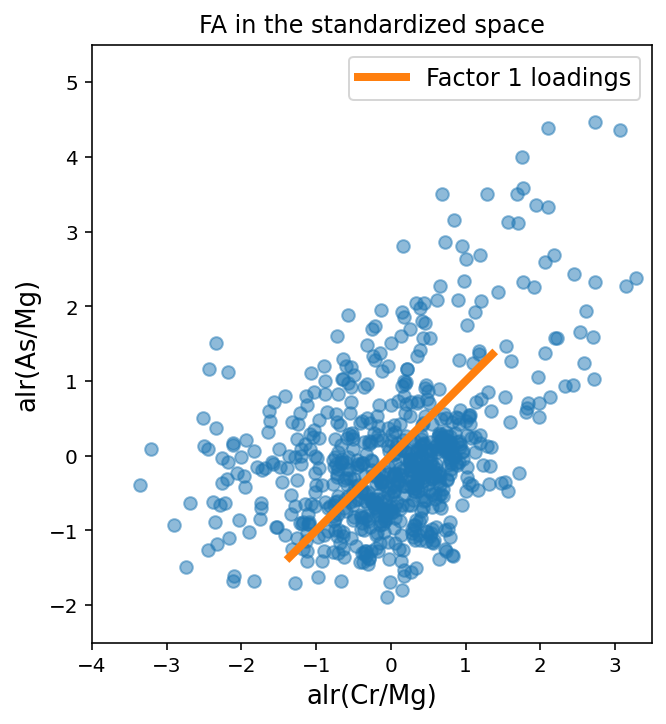

In [ ]:
plt.figure(figsize=(7,5.5))

## plot first factor
plt.scatter(X_scaler[:,0], X_scaler[:,1], s=40, alpha=0.5)
vis_scale = 5
plt.plot([-fa.loadings_[0]*fa.get_factor_variance()[1]*vis_scale, fa.loadings_[0]*fa.get_factor_variance()[1]*vis_scale], 
         [-fa.loadings_[1]*fa.get_factor_variance()[1]*vis_scale, fa.loadings_[1]*fa.get_factor_variance()[1]*vis_scale], label="Factor 1 loadings", linewidth=4, color='C1')

plt.axis('square')
plt.xlabel('alr(Cr/Mg)', fontsize = 13)
plt.ylabel('alr(As/Mg)', fontsize = 13)
plt.legend(fontsize = 12)
plt.ylim(-2.5,5.5)
plt.xlim(-4,3.5)
plt.title('FA in the standardized space')

plt.show()


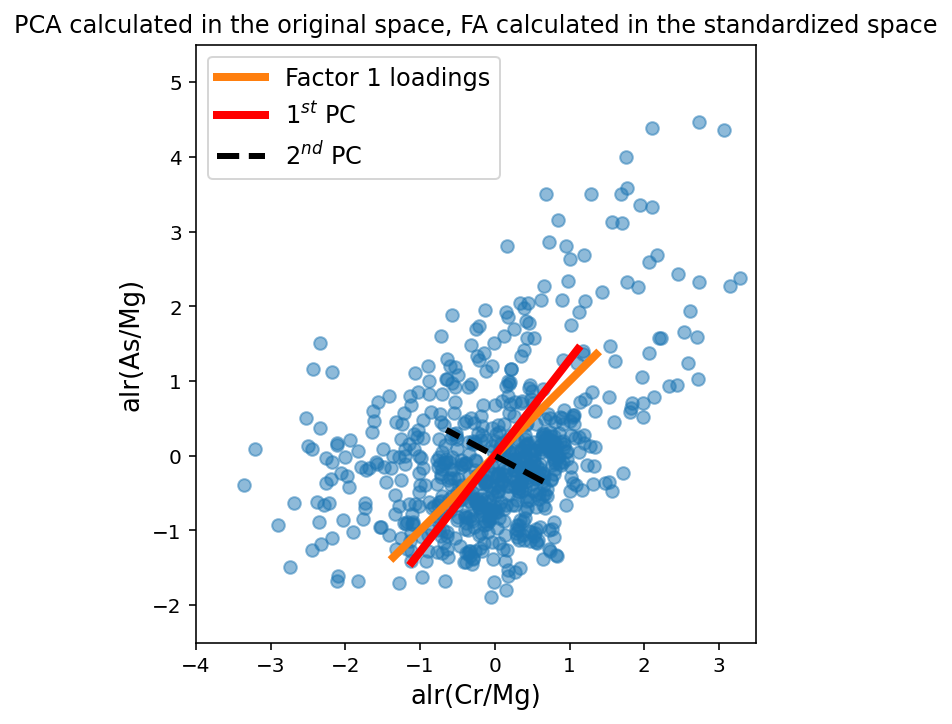

In [ ]:
plt.figure(figsize=(7,5.5))

## plot first factor
plt.scatter(X_scaler[:,0], X_scaler[:,1], s=40, alpha=0.5)
plt.plot([-fa.loadings_[0]*fa.get_factor_variance()[1]*vis_scale, fa.loadings_[0]*fa.get_factor_variance()[1]*vis_scale], 
         [-fa.loadings_[1]*fa.get_factor_variance()[1]*vis_scale, fa.loadings_[1]*fa.get_factor_variance()[1]*vis_scale], label="Factor 1 loadings", linewidth=4, color='C1')

comp = pca.components_[0] * pca.explained_variance_ratio_[0] 
plt.plot([-comp[0]*vis_scale, comp[0]*vis_scale], 
         [-comp[1]*vis_scale, comp[1]*vis_scale], label="1$^{st}$ PC", linewidth=4, color='r')
comp = pca.components_[1] * pca.explained_variance_ratio_[1]  
plt.plot([-comp[0]*vis_scale, comp[0]*vis_scale], 
         [-comp[1]*vis_scale, comp[1]*vis_scale], linewidth=3, color='k', label="2$^{nd}$ PC",linestyle='--')


plt.axis('square')
plt.xlabel('alr(Cr/Mg)', fontsize = 13)
plt.ylabel('alr(As/Mg)', fontsize = 13)
plt.legend(fontsize = 12)
plt.ylim(-2.5,5.5)
plt.xlim(-4,3.5)

plt.title('PCA calculated in the original space, FA calculated in the standardized space')
plt.show()


In [ ]:
# plt.figure(figsize=(7,5.5))

# pca = PCA(n_components=X.shape[1])
# pca.fit(X_scaler)
# ## plot first factor
# plt.scatter(X_scaler[:,0], X_scaler[:,1], s=40, alpha=0.5)
# plt.plot([-fa.loadings_[0]*fa.get_factor_variance()[1]*vis_scale, fa.loadings_[0]*fa.get_factor_variance()[1]*vis_scale], 
#          [-fa.loadings_[1]*fa.get_factor_variance()[1]*vis_scale, fa.loadings_[1]*fa.get_factor_variance()[1]*vis_scale], label="Factor 1 loadings", linewidth=4, color='C1',zorder = 4)

# comp = pca.components_[0] * pca.explained_variance_ratio_[0] 
# plt.plot([-comp[0]*vis_scale, comp[0]*vis_scale], 
#          [-comp[1]*vis_scale, comp[1]*vis_scale], label="1$^{st}$ PC", linewidth=4, color='r')
# comp = pca.components_[1] * pca.explained_variance_ratio_[1]  
# plt.plot([-comp[0]*vis_scale, comp[0]*vis_scale], 
#          [-comp[1]*vis_scale, comp[1]*vis_scale], linewidth=3, color='k', label="2$^{nd}$ PC",linestyle='--')


# plt.axis('square')
# plt.xlabel('alr(Cr/Mg)', fontsize = 13)
# plt.ylabel('alr(As/Mg)', fontsize = 13)
# plt.legend(fontsize = 12)
# plt.ylim(-2.5,5.5)
# plt.xlim(-4,3.5)

# plt.title('PCA, FA both calculated in the standardized space')

# plt.show()


Loading: 

[0.64759646 0.64759646]


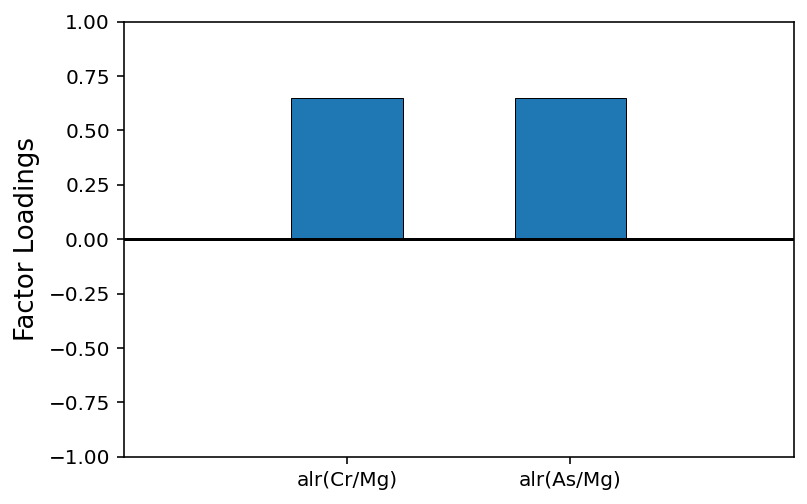

In [ ]:
plt.bar(['alr(Cr/Mg)', 'alr(As/Mg)'], fa.loadings_.T[0], edgecolor='k', linewidth=0.5, width=0.5)
plt.hlines(y=0, xmin=-2, xmax=2)
plt.xlim(-1, 2)
plt.ylim(-1, 1)
plt.ylabel('Factor Loadings', fontsize=13)
print(fa.loadings_.T[0])

Factor scores:

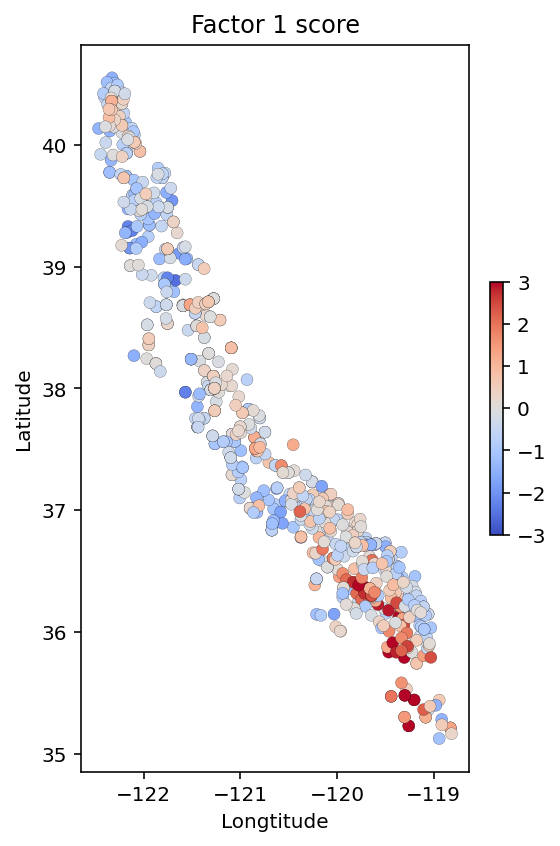

In [ ]:
plt.figure(figsize=(4,6))
plt.scatter(data['Longitude'],data['Latitude'],
            c = X_fa_scaler[:,0], cmap = 'coolwarm', vmax=3, vmin=-3, edgecolor='k', linewidth=0.1)
plt.colorbar(fraction=0.03)
plt.title('Factor 1 score')
plt.xlabel('Longtitude')
plt.ylabel('Latitude')
plt.tight_layout()

## The common factor $F_1$ characterizes correlations betweeen $X_1$ and $X_2$ 


The correlation matrix of $X$ or the covariance matrix of $X$ after standardization:

In [ ]:
pd.DataFrame(np.corrcoef(X.T), columns = ['X1','X2'],  index = ['X1','X2'])

X1        X2
X1  1.000000  0.419381
X2  0.419381  1.000000

The covariance matrix of the common factor: $l_{11}*F_1$ and $l_{21}*F_1$

In [ ]:
pd.DataFrame(np.matmul(fa.loadings_,fa.loadings_.T), 
             columns = ['l11F1','l21F1'], 
             index = ['l11F1','l21F1'])

l11F1     l21F1
l11F1  0.419381  0.419381
l21F1  0.419381  0.419381

In these two matrix, the off-diagonal values are the same. Therefore, the correlation between $X_1$ and $X_2$ is explained by the common factor $F_1$. This factor also explains 41.9% variance in this dataset. 

The rest of the variance (diagonal) is explained by the error term/unique part $\varepsilon_1$ and $\varepsilon_2$: 100%-41.9% = 58.1%.  

Then the theoretical covariance matrix of the unique part $\varepsilon_1$ and $\varepsilon_2$ is: 

In [ ]:
pd.DataFrame(np.diag(fa.get_uniquenesses()), 
             columns = ['epsilon1','epsilon2'], 
             index = ['epsilon1','epsilon2'])

epsilon1  epsilon2
epsilon1  0.580619  0.000000
epsilon2  0.000000  0.580619

If we calculate the covariance matrix empirically: 

In [ ]:
epsilon = X_scaler-np.matmul(X_fa_scaler,fa.loadings_.T)

In [ ]:
pd.DataFrame(np.cov(epsilon.T), 
             columns = ['epsilon1','epsilon2'], 
             index = ['epsilon1','epsilon2'])

epsilon1  epsilon2
epsilon1  0.328751 -0.252719
epsilon2 -0.252719  0.328751

which deviates from the the theoretical result. These off-diagonal values actually give an indication of how well the factor model fits the data.

In PCA, we don't have this lack-of-fit because we don't assume any latent variables. We find the maximium variance axis in PCA. 

Text(0, 0.5, '$\\epsilon_2$')

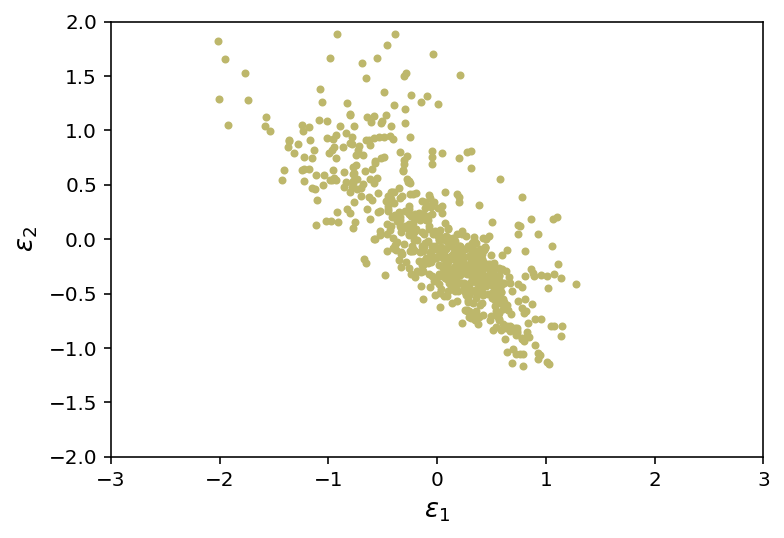

In [ ]:
plt.plot(epsilon[:,0],epsilon[:,1],'.',color = 'darkkhaki')
plt.xlim(-3,3)
plt.ylim(-2,2)
plt.gca().set(aspect='equal')
plt.xlabel('$\epsilon_1$', fontsize = 13)
plt.ylabel('$\epsilon_2$', fontsize = 13)

Also we can compare the error terms for both FA and PCA. In PCA, the "error terms" are linear to PC2. Therefore, errors are linearly correlated. In FA, theoretically, there is no correlation between the error terms, which should be a round cloud. 

# Difference between PCA and FA

|     | Focus       | Reconstruction | Latent variable | Error variables |
|-----|-------------|----------------|-----------------|-------------------|
| PCA | Explain variance    | Yes            | No              | Linearly correlated            |
| FA  | Explain correlation | No             | Yes             | Uncorrelated   |

# Factor analysis on Iris dataset

Recall what we see earlier in the class, the biplot of the iris dataset.

<img src='https://drive.google.com/uc?export=view&id=1aUyTAU9T0UZvnLklq46JuXN54UTkemgc' width=100% />


## Principal Component Analysis on Iris dataset: 

In [ ]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data

In [ ]:
pca = PCA(n_components=X.shape[1])
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

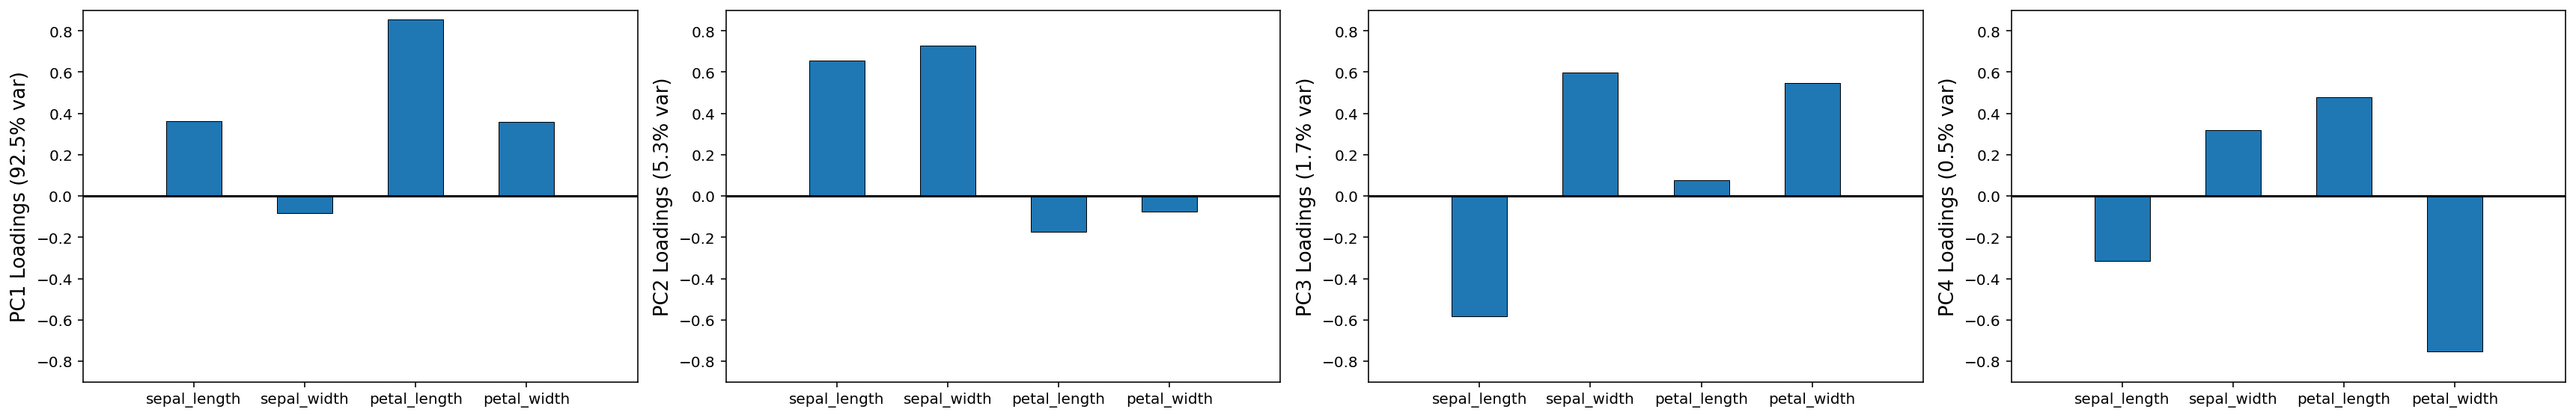

In [ ]:
plt.figure(figsize=(24,4))
for i in range(4):
  plt.subplot(1, 4, i+1)
  plt.bar(['sepal_length', 'sepal_width','petal_length','petal_width'], pca.components_[i], edgecolor='k', linewidth=0.5, width=0.5)
  plt.hlines(y=0, xmin=-1, xmax=4)
  plt.xlim(-1, 4)
  plt.ylim(-0.9, 0.9)
  plt.ylabel('PC'+str(i+1)+' Loadings ({:.1f}% var)'.format(100*pca.explained_variance_ratio_[i]), fontsize=13)
plt.tight_layout()

## Factor analysis on Iris dataset

Let's find the latent factors to explain the correlation in the iris dataset. 

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)

In [ ]:
from factor_analyzer import FactorAnalyzer
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors = 2, rotation = 'varimax',method='minres')
fa.fit(X)
X_fa =fa.transform(X)
X_fa_scaler = scaler.fit_transform(X_fa)

In [ ]:
fa.loadings_.T

array([[ 0.90120548, -0.15041281,  0.96415345,  0.92140125],
       [ 0.01789008,  0.98619517, -0.28461929, -0.23324486]])

How do you explain the factors? 

Factor 1: The flower size of the iris? 

Text(0, 0.5, 'Factor 1 Loadings')

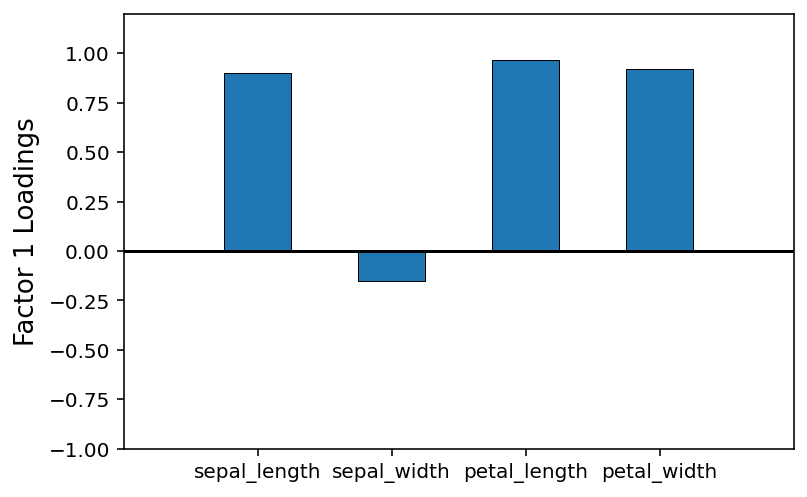

In [ ]:
plt.bar(['sepal_length', 'sepal_width','petal_length','petal_width'], 
        fa.loadings_.T[0], edgecolor='k', linewidth=0.5, width=0.5)
plt.hlines(y=0, xmin=-2, xmax=5)
plt.xlim(-1, 4)
plt.ylim(-1, 1.2)
plt.ylabel('Factor 1 Loadings'.format(i+1), fontsize=13)

Factor 2: The difference between the sepal and petal? 

Text(0, 0.5, 'Factor 2 Loadings')

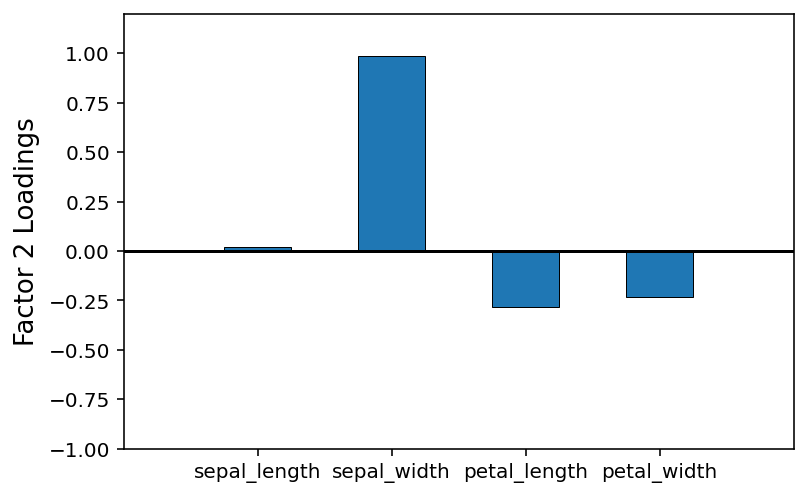

In [ ]:
plt.bar(['sepal_length', 'sepal_width','petal_length','petal_width'], 
        fa.loadings_.T[1], edgecolor='k', linewidth=0.5, width=0.5)
plt.hlines(y=0, xmin=-2, xmax=5)
plt.xlim(-1, 4)
plt.ylim(-1, 1.2)
plt.ylabel('Factor 2 Loadings'.format(i+1), fontsize=13)

Let's again investigate how these 2 factors explain the correlation matrix. 


The correlation matrix:

In [ ]:
pd.DataFrame(np.corrcoef(X.T), columns =['sepal_length', 'sepal_width','petal_length','petal_width'],  
             index = ['sepal_length', 'sepal_width','petal_length','petal_width'])

sepal_length  sepal_width  petal_length  petal_width
sepal_length      1.000000    -0.117570      0.871754     0.817941
sepal_width      -0.117570     1.000000     -0.428440    -0.366126
petal_length      0.871754    -0.428440      1.000000     0.962865
petal_width       0.817941    -0.366126      0.962865     1.000000

The covariance explained by the common factors $F_1$, $F_2$: 

In [ ]:
pd.DataFrame(np.matmul(fa.loadings_,fa.loadings_.T), 
             columns = ['Comm_sepal_l','Comm_sepal_w','Comm_pedal_l','Comm_pedal_w'],
             index = ['Comm_sepal_l','Comm_sepal_w','Comm_pedal_l','Comm_pedal_w'])

Comm_sepal_l  Comm_sepal_w  Comm_pedal_l  Comm_pedal_w
Comm_sepal_l      0.812491     -0.117910      0.863809      0.826199
Comm_sepal_w     -0.117910      0.995205     -0.425711     -0.368616
Comm_pedal_l      0.863809     -0.425711      1.010600      0.954758
Comm_pedal_w      0.826199     -0.368616      0.954758      0.903383

The covariance of the unique terms $\varepsilon_1$, $\varepsilon_2$, $\varepsilon_3$, $\varepsilon_4$:

In [ ]:
epsilon = X_scaler-np.matmul(X_fa_scaler,fa.loadings_.T)

In [ ]:
pd.DataFrame(np.cov(epsilon.T), 
             columns = ['epsilon1','epsilon2','epsilon3','epsilon4'], 
             index = ['epsilon1','epsilon2','epsilon3','epsilon4'])

epsilon1  epsilon2  epsilon3  epsilon4
epsilon1  0.211882  0.003841  0.030469  0.013449
epsilon2  0.003841  0.000502  0.002145  0.007035
epsilon3  0.030469  0.002145  0.010715  0.028938
epsilon4  0.013449  0.007035  0.028938  0.117440

Text(0, 0.5, '$\\epsilon_2$')

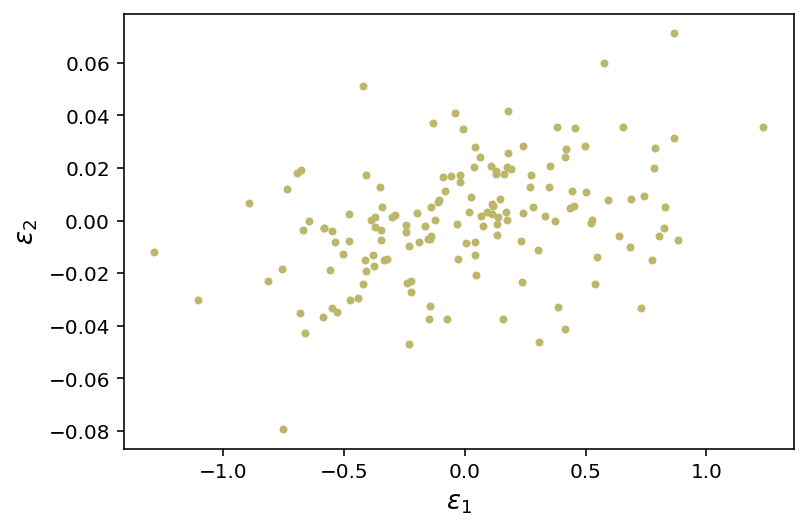

In [ ]:
plt.plot(epsilon[:,0],epsilon[:,1],'.',color = 'darkkhaki')
plt.xlabel('$\epsilon_1$', fontsize = 13)
plt.ylabel('$\epsilon_2$', fontsize = 13)

## Communality

The factor model for the iris dataset: 
$$X_1 =  l_{11}*F_1+l_{12}*F_2+\varepsilon_1$$
$$X_2 = l_{21}*F_1+l_{22}*F_2+\varepsilon_2$$
$$X_3 =  l_{31}*F_1+l_{32}*F_2+\varepsilon_3$$
$$X_4 = l_{41}*F_1+l_{42}*F_2+\varepsilon_4$$


Here all factor scores $F_1$, $F_2$ have been standardized (mean = 0, variance = 1).  

Q1. What portion of the variance in $X_2$ has been explained by $F_2$?

$$l_{22}^2$$


In [ ]:
fa.loadings_[1,1]**2 #python starts counting from 0

0.9725809172123837

Q2. What portion of the variance in this iris dataset has been explained by $F_2$?


$$(\sum_{i = 1}^{4} l_{i2}^2)/4 = (l_{12}^2+l_{22}^2+l_{32}^2+l_{42}^2)/4$$

4 is the number of observed variables. 

In [ ]:
np.sum(fa.loadings_[:,1]**2)/4

0.27707806898461357

Q3. What portion of the variance in $X_1$ has been explained by these two factors? 


$$\sum_{j = 1}^{3} l_{1j}^2 = l_{11}^2+l_{12}^2$$


2 is the number of factors. 

In [ ]:
np.sum(fa.loadings_[0,:]**2)

0.8124913690741936

**Definition:** 

*  The communalities for the $i^{th}$ variable are computed by taking the sum of the squared loadings for that variable: 

$$\sum_{j = 1}^{f} l_{ij}^2$$

$f$ is the number of factors. 

The communality for a given variable can be interpreted as the proportion of variation in that variable explained by $f$ factors.




In [ ]:
np.sum(fa.loadings_**2,axis = 1)

array([0.81249137, 0.99520493, 1.01060002, 0.90338342])

*  The total communality:

$$\sum_{i = 1}^{n} \sum_{j = 1}^{f} l_{ij}^2$$

$n$ is the number of observed variables. $f$ is the number of factors. 

*  The proportion of the total variation explained by $f$ factors:

$$(\sum_{i = 1}^{n} \sum_{j = 1}^{f} l_{ij}^2)/n$$

In [ ]:
## Total communality
np.sum(fa.loadings_**2)

3.7216797381151445

In [ ]:
## Total explained variance 
np.sum(fa.loadings_**2)/4

0.9304199345287861

In [ ]:
## Proportional variance for each factor: F1, F2
np.sum(fa.loadings_**2,axis = 0)/4

array([0.65334187, 0.27707807])

# Factor analysis on Central Valley geochemistry

In [ ]:
## import silhouette index caculation function. 
! git clone https://github.com/sdyinzhen/GS240_resources
import sys
sys.path.append('/content/GS240_resources/FA')
from loadings_plot import *

Cloning into 'GS240_resources'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 92 (delta 30), reused 69 (delta 13), pack-reused 0
Unpacking objects: 100% (92/92), done.


### Data overview and log ratio transformation (alr)
For demonstration, we choose As, Cr, Mg, Mn, Cl, NO3, Fe and U (8 elements) from the central valley dataset to perform Factor Analysis. 

In [ ]:
data = pd.read_csv('/content/GEOLSCI6_EARTHSYS100A/StatsGeochem/Datapoints-CentralValley-Groundwater-Jan2019.csv')
data = data.loc[:, ['Latitude', 'Longitude','Mg (ppb)','Mn (ppb)',
                      'Cl (ppb)','As (ppb)', 'Cr (ppb)',  'NO3 (ppb)', 
                      'Fe (ppb)', 'U (ppb)']]
data

Latitude   Longitude  Mg (ppb)  ...  NO3 (ppb)  Fe (ppb)   U (ppb)
0    39.767667 -121.781556     10300  ...        474       3.2  0.117068
1    37.757111 -120.799278      9310  ...       4390       4.0  0.356680
2    37.757111 -120.799278     10200  ...       4340       8.4  0.307840
3    38.287528 -121.328972      6460  ...        238      81.0  0.156880
4    38.287528 -121.328972      6150  ...        298      90.8  0.281200
..         ...         ...       ...  ...        ...       ...       ...
678  38.686806 -121.766306     57300  ...       5170       4.0  1.568800
679  38.686806 -121.766306     54600  ...       6610       4.2  1.149960
680  38.686806 -121.766306     45400  ...       7190       8.0  1.613200
681  38.574444 -121.770389     95200  ...      18600       4.2  3.108000
682  38.521917 -121.964722     40600  ...        556       5.2  1.613200

[683 rows x 10 columns]

Here we perform additive log ratio transformation with Mg as basis. 

In [ ]:
choice_d = 0 # 'Pb'
base = '/Mg'

# Load geochem dataset, groundwater chemistry in Central Valley
compositional_data = np.array(data.values[:,2:],dtype = 'float64')
lr_data = alr(compositional_data, denominator_idx=choice_d)
lr_type = 'alr'
lr_data_col_names = []
name_ind = np.delete(np.arange(2,len(compositional_data[0])+2), choice_d)
for i in name_ind:
  if data.columns[i][2]=='(' or data.columns[i][2]==' ':
    lr_data_col_names.append(lr_type+'('+data.columns[i][:2]+base+')')
  else:
    lr_data_col_names.append(lr_type+'('+data.columns[i][:3]+base+')')
lr_data = pd.DataFrame(lr_data, columns = lr_data_col_names[:compositional_data.shape[1]])
lr_data.head()

alr(Mn/Mg)  alr(Cl/Mg)  alr(As/Mg)  ...  alr(NO3/Mg)  alr(Fe/Mg)  alr(U /Mg)
0  -10.512865   -1.150417   -9.475622  ...    -3.078692   -8.076748  -11.384899
1  -10.055135   -0.046162   -8.956523  ...    -0.751760   -7.752550  -10.169761
2  -10.308953   -0.427771   -8.967779  ...    -0.854513   -7.101911  -10.408318
3   -3.890583    0.138550   -5.686898  ...    -3.301114   -4.378935  -10.625659
4   -3.687255    0.227362   -5.656154  ...    -3.027114   -4.215548   -9.992896

[5 rows x 7 columns]

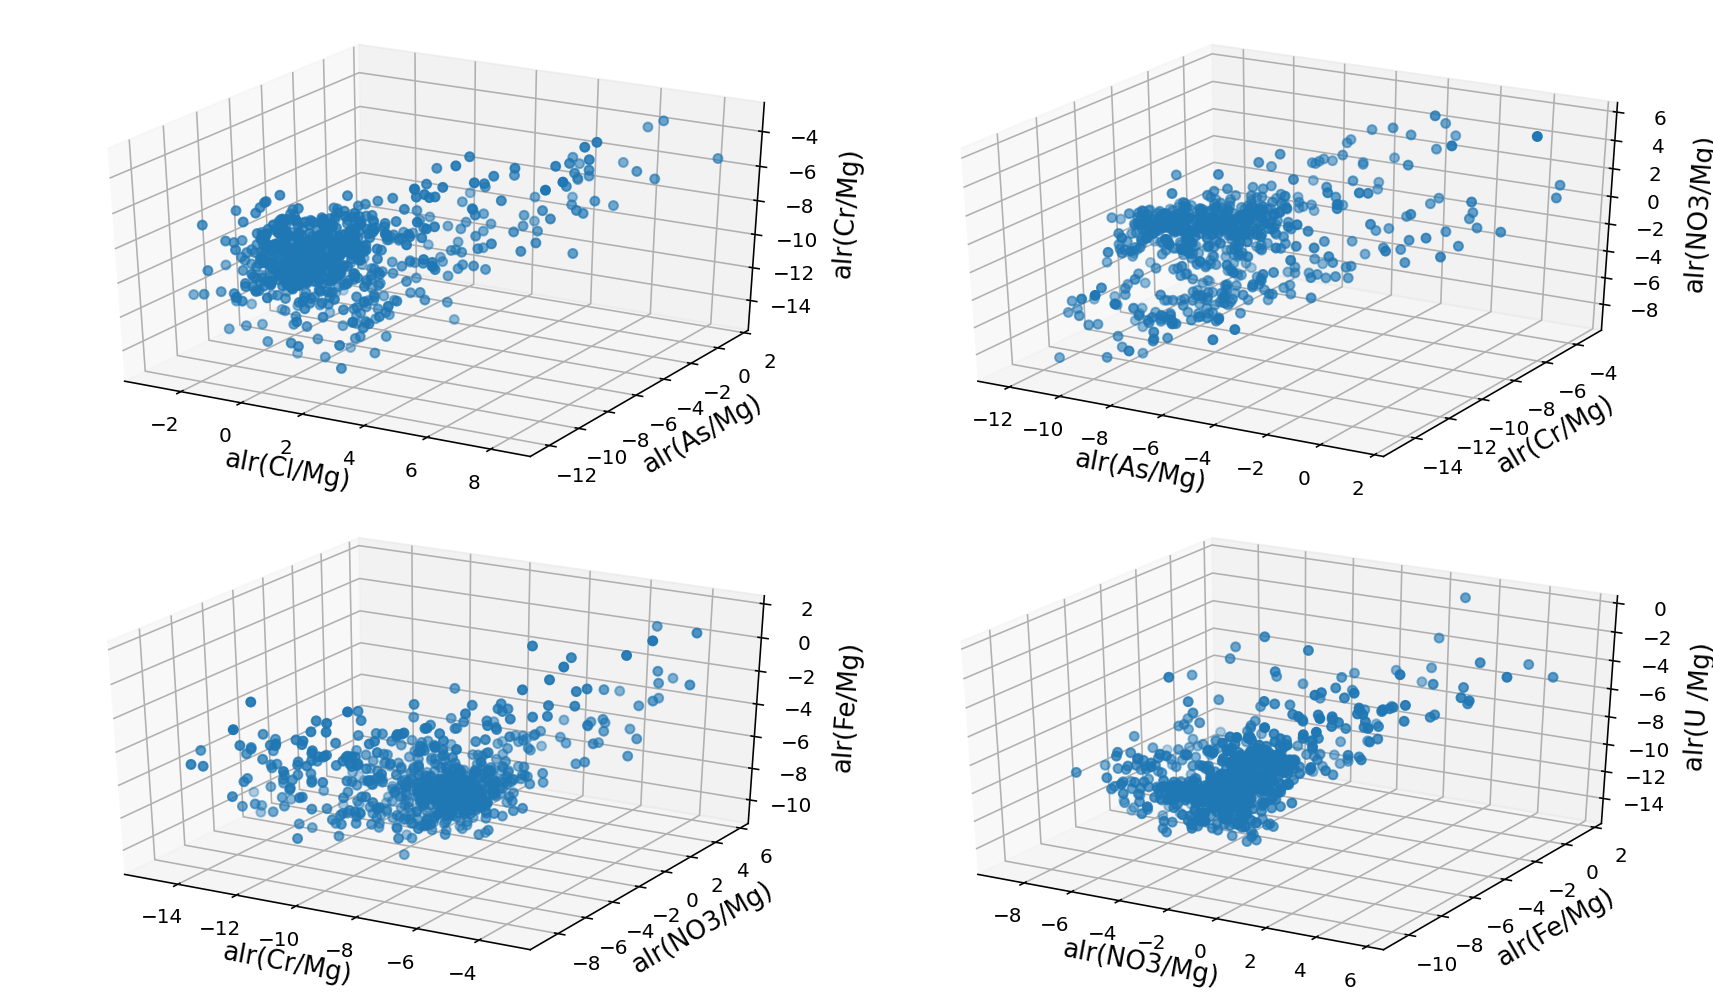

In [ ]:
X = lr_data.values
loading_names = lr_data.columns.values.tolist()
fig = plt.figure(figsize=(12,7))
for i in range(1,5):
  ax = fig.add_subplot(2,2,i, projection='3d')
  ax.scatter(X[:,i],X[:,i+1], X[:,i+2])
  ax.set_xlabel(loading_names[i], fontsize = 13)
  ax.set_ylabel(loading_names[i+1], fontsize = 13)
  ax.set_zlabel(loading_names[i+2], fontsize = 13)
plt.tight_layout()

## Factor analysis on log ratio transformed data
How to determine the number of factors:
1. Cummunality  (e.g. 80% explained variance) 
2. Scree plot (based on the "elbow" of the plot)


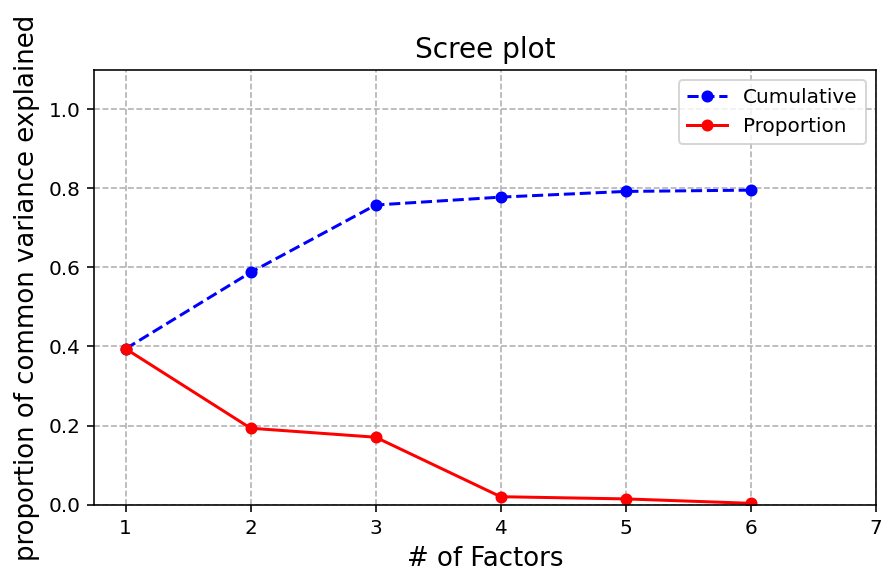

In [ ]:
from factor_analyzer import FactorAnalyzer
# Create factor analysis object and perform factor analysis
n_fctrs = X.shape[1]-1
fa = FactorAnalyzer(n_factors = n_fctrs, rotation = 'varimax',method='minres')
fa.fit(X)
X_fa =fa.transform(X)
fa_loadings = fa.loadings_.T

# var_total = np.sum(X.var(axis=0))
commumalities = np.sum(fa_loadings**2, axis=1)
var_explained_prop = commumalities/X.shape[1]

plt.figure(figsize=(7, 4))
plt.plot(np.arange(1,X.shape[1]), var_explained_prop.cumsum(), \
          marker='o', markersize=5, linestyle = 'dashed', color='blue', label='Cumulative')
plt.plot(np.arange(1,X.shape[1]), var_explained_prop, \
          marker='o', markersize=5, color='red', label='Proportion')
plt.xlabel('# of Factors', fontsize = 13)
plt.ylabel('proportion of common variance explained', fontsize = 13)
plt.xticks(np.arange(1,X.shape[1]+1,1))
plt.ylim(0,1.1)
plt.legend()
plt.title('Scree plot', fontsize = 14)
plt.grid(linestyle='dashed')

## Plot results of FA with large dataset

Calculate variance explained using communality

In [ ]:
# var_total = np.sum(X.var(axis=0))
commumalities = np.sum(fa_loadings**2, axis=1)
var_explained_prop = commumalities/X.shape[1]

Below we plot loadings of the first four loadings. They account for 78% of total variance explained. 



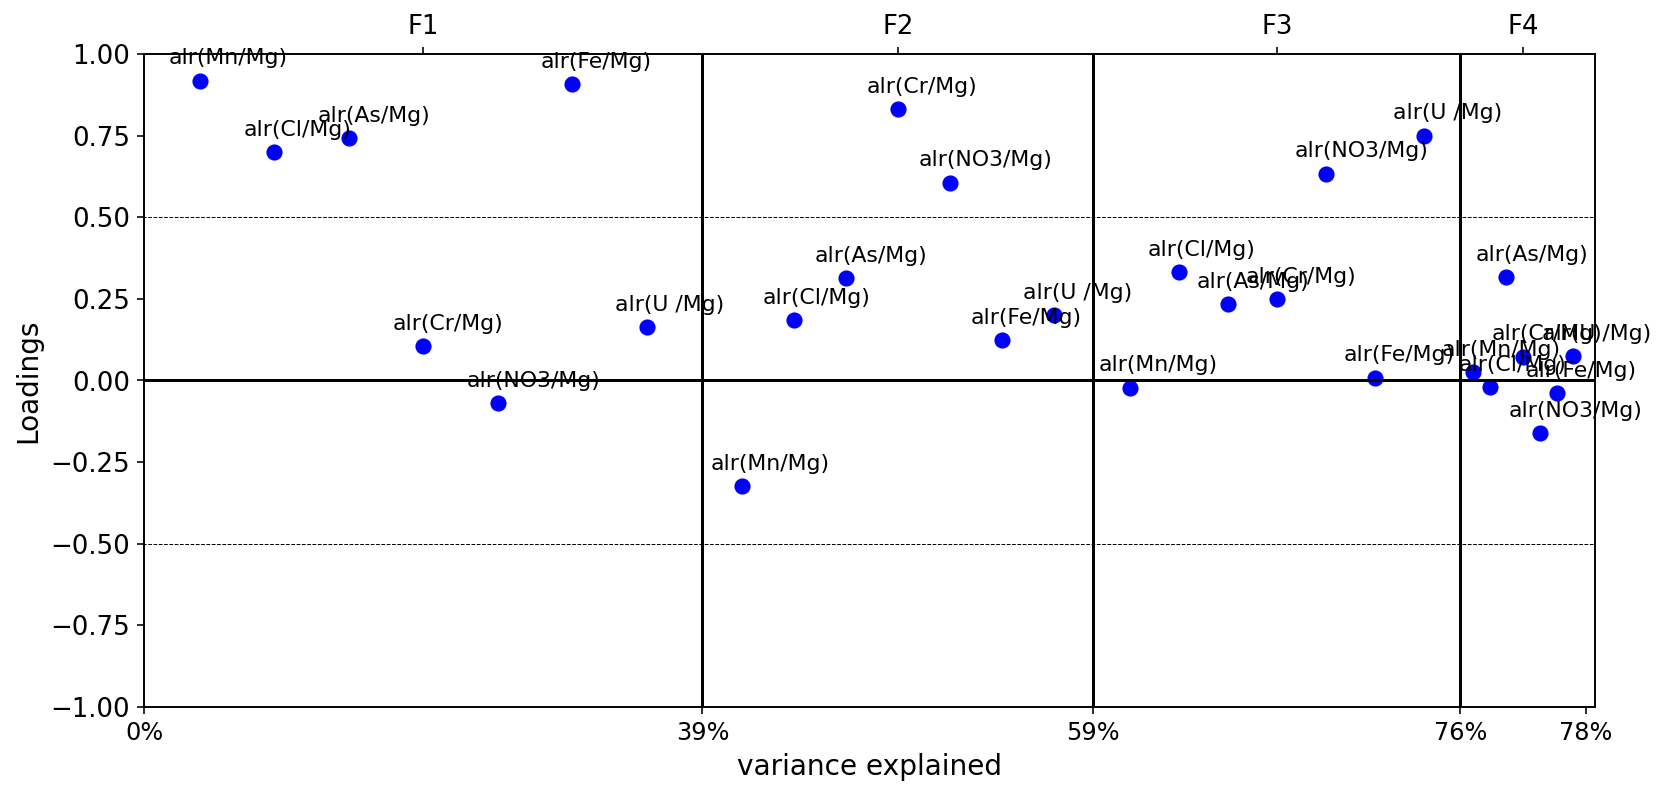

In [ ]:
plt_fctrs = 4
loadings_plot(fa_loadings, loading_names, var_explained_prop, n_fctr=plt_fctrs)

From the loading plot, we observe geochemically F2 is dominated by the groundwater contaminants of Cr,As & U. 

Visually compare F2 with the landuse map. Try to explain what Landusages are correlated to F2 ? You can notice that the high contaminations (high F2 values) tend be observed near Developed areas. 





In [ ]:
fig = plt.figure(figsize=(8,6))
plt.subplot(121)

plt.scatter(data['Longitude'],data['Latitude'],
            c = X_fa[:,1],cmap = 'coolwarm',vmin=-2, vmax = 2)
plt.colorbar(fraction=0.03)
plt.title('Factor 2')
plt.xlabel('Longtitude')
plt.ylabel('Latitude')

from PIL import Image

plt.subplot(122)
img = Image.open('/content/GS240_resources/FA/landuse.jpg')
plt.imshow(img.resize((550,950)))
plt.axis('off')
plt.title('Landuse')
plt.tight_layout()


## Important notes

**NB: The best way to perform FA on compositional data is to use clr transformation with following steps.** [See reference: Discovering geochemical patterns by factor-based cluster analysis](https://www.sciencedirect.com/science/article/pii/S0375674217301796)

Step 1: Perform clr transformation of the observed variables;

Step 2: Transform the clr-transformed variables into the ilr space, and estimate the correlation matrix based on ilr-transformed variables;

Step 3: Back-transform the correlation matrix to the counterpart in clr space;

Step 4: Implement factor analysis based on the correlation matrix obtained in Step 3.